----

### Content of this notebook: 

### Step 5) Data Handling
   - This step involves the necessary preprocessing steps to prepare the data for input into the LSTM models. It includes:

     - **Proper Data Handling:** Ensuring that all missing values are dealt with and the dataset is clean and ready for analysis.
     - **Train-Test Split:** The data is divided into training and testing sets. The training set will be used to train the models, while the testing set will be used to evaluate the models' performance.
     - **Scaling (Min-Max):**  Scaling the features to a range [0, 1] using MinMaxScaler to ensure that the LSTM model, which is sensitive to the scale of the data, can perform optimally.
     - **Reshaping to 3D as LSTM Input Requires:** Since LSTMs expect 3D input in the form of [samples, timesteps, features], the data is reshaped accordingly to meet these requirements.
     - **Defining Lookback Length:** The lookback length determines how many previous time steps are used to predict the next value. It is a crucial parameter in sequence data.
     - **Sequence Data Generation Using Time Series Generator:** The TimeseriesGenerator is used to generate sequences of data along with their corresponding labels, which the LSTM models will use for training.

### Step 6) Model Building & Hyperparameter Optimization
  - This step outlines the process of building various deep learning models to predict SPY ETF trends and optimizing their performance.

     - **Model Building:**
         - Several models are constructed, including:
            - **Base LSTM:** A simple LSTM model with a single LSTM layer.
            - **LSTM with 2 layers:** This model includes two LSTM layers stacked together.
            - **LSTM with 5 layers:** A deeper model with five LSTM layers.
            - **GRU:** A model using Gated Recurrent Units (GRU), which is an alternative to LSTM.
            - **LSTM combined with CNN:** A hybrid model that combines LSTM layers with Convolutional Neural Network (CNN) layers.

     - **Hyperparameter Tuning:**
        - For each model, hyperparameters like the number of units in LSTM/GRU layers, dropout rates, learning rates, and CNN filter sizes are optimized using **RandomSearch.**
           - **Early Stopping:** This is used to prevent the model from overfitting by stopping the training process once the performance on the validation set stops improving.
           - **TensorBoard Integration:** TensorBoard is integrated to visualize the training process, including the loss and accuracy over epochs.
           
           
### Step 7) Model Evaluation
    
**Evaluation Metrics and Trading Strategy Backtesting**

   - After building and optimizing the LSTM models, we evaluate the performance of the model with Evaluatioon Metrics and by simulating a trading strategy based on the LSTM model’s signals. This is done by backtesting the strategy on the test period from April 2023 to June 2024.


- **7.1) Evaluation Metrics:**
  - Before implementing the trading strategy backtest, we evaluated the LSTM models' performance using various classification metrics. These included:

    - **Accuracy:** Measures the percentage of correct predictions made by the model.
    - **F1 Score:** Provides a balance between precision and recall, offering a single metric to evaluate the model’s overall performance.
    - **Precision:** Indicates the ratio of correctly predicted positive observations to the total predicted positives.
    - **Recall:** Reflects the ratio of correctly predicted positive observations to all observations in the actual class.
    - **AUC and ROC:** Used to measure the model’s ability to distinguish between classes.
    - **Confusion Matrix:** Provides insight into the true positive, true negative, false positive, and false negative predictions.
    - **Balanced Accuracy:** Adjusts accuracy for any imbalanced classes, ensuring a more reliable evaluation.
- **These metrics were crucial in selecting the best model, which was then used for backtesting the trading strategy.**

### Please note that Complete Trading Strategy and Backtest part of the project is in Notebook-3 (CQF-DL-Trading-Backtest) ipynb



---

### Importing Required Libraries

In [1]:
# Import TensorFlow and Keras
import tensorflow as tf
# Check TensorFlow version
print("TensorFlow version is", tf.version.VERSION)

# Suppress TensorFlow warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.CRITICAL)



TensorFlow version is 2.17.0


In [118]:
import warnings
warnings.filterwarnings("ignore")

# Base libraries
import os
import random
import numpy as np
import pandas as pd
import datetime
from pathlib import Path
import pydot
import datetime as dt


# Scikit-learn modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import class_weight

# TensorFlow and Keras modules
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, GRU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import Metric, BinaryAccuracy, Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives


# Plotting & outputs
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
from pprint import pprint

# Keras Tuner for hyperparameter optimization
import keras_tuner as kt

# QuantStats for backtesting report
import quantstats as qs

# Alphavantage for fetching data
from alpha_vantage.timeseries import TimeSeries

#### Loading TensorBoard Extension

- **TensorBoard Integration:** TensorBoard is a powerful visualization tool designed to help in monitoring and debugging deep learning models during training. By loading this extension, you can launch TensorBoard directly within the notebook, allowing you to visualize metrics such as loss, accuracy, and other relevant statistics in real-time as your models train.

- **Real-Time Monitoring:** This integration provides a convenient way to track model performance, monitor the effects of hyperparameter tuning, and detect issues like overfitting during the training process. By visualizing metrics in real time, you can make informed decisions about when to stop training or when to adjust parameters.

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

### Step 5) Data Handling
- This step involves the necessary preprocessing steps to prepare the data for input into the LSTM models

- **5.1) Loading the Dataset:** Loading the dataset SPY_Final_Features_Dataset.csv into a pandas DataFrame named df.      This dataset contains the final set of 24 features that were selected after performing feature engineering and selection.

In [4]:
# Load the dataset
df = pd.read_csv('SPY_Final_Features_Dataset.csv')

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

df

,date,daily_return,yield_spread,VXX_daily_return,UUP_daily_return,volume_tech,ADOSC_3_10,ADX_14,OBV,AOBV_SR_2,...,PDIST,PIVOTS_TRAD_D_P,PIVOTS_TRAD_D_R3,PSL_12,PVOL,PVT,SLOPE_1,SMCtp_14_50_20_5,STDEV_30,Target
0,2017-07-05,0.002312,0.92,0.000775,0.000402,54427600.0,0.000000e+00,0.000000,5.442760e+07,0.0,...,0.020000,0.020000,0.020000,100.000000,1.321339e+10,3.855400e+00,0.000000,-7.203386,0.000000,1.0
1,2017-07-06,-0.009144,0.97,0.051123,-0.004416,65400800.0,0.000000e+00,0.000000,-1.097320e+07,0.0,...,2.920015,242.493332,245.113328,99.085554,1.573216e+10,-5.980551e+07,-2.220001,-7.203386,1.360001,0.0
2,2017-07-07,0.006485,0.99,-0.036109,0.001613,56062000.0,0.000000e+00,0.000000,4.508880e+07,0.0,...,3.200012,240.973333,244.353339,100.000000,1.357317e+10,-2.344858e+07,1.559998,-7.203386,0.250000,1.0
3,2017-07-10,0.001074,0.98,-0.024465,0.000403,36663274.0,0.000000e+00,0.000000,8.175207e+07,0.0,...,1.820001,241.649999,245.090001,100.000000,8.886078e+09,-1.951135e+07,0.259999,-7.203386,1.200002,0.0
4,2017-07-11,-0.000743,1.00,-0.003918,-0.003622,50290920.0,2.419980e+02,241.998002,3.146115e+07,0.0,...,3.580000,242.310000,244.390000,99.925733,1.217996e+10,-2.324629e+07,-0.180000,-7.203386,0.910000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,2024-06-24,-0.003251,-0.46,-0.007972,-0.003436,45528654.0,3.742017e+07,26.137312,1.641817e+09,1.0,...,7.250000,544.393333,549.653333,58.333333,2.471022e+10,-1.149704e+10,-1.770000,-7.034976,7.967939,0.0
1742,2024-06-25,0.003851,-0.42,-0.017857,0.001034,38273346.0,3.392215e+07,26.493766,1.680090e+09,1.0,...,5.930000,544.103333,552.763333,66.666667,2.085247e+10,-1.148231e+10,2.090000,-10.189487,7.897289,1.0
1743,2024-06-26,0.001248,-0.39,-0.010909,0.004823,38550637.0,3.609444e+07,27.023626,1.718641e+09,0.0,...,5.740000,544.156667,549.676667,75.000000,2.102976e+10,-1.147750e+10,0.680000,-20.033204,7.778476,0.0
1744,2024-06-27,0.001577,-0.41,-0.006434,-0.001371,35041480.0,3.925285e+07,27.653751,1.753682e+09,0.0,...,3.840000,544.926667,551.346667,75.000000,1.914561e+10,-1.147197e+10,0.860000,-25.013835,7.748247,0.0


In [5]:
df.dtypes

date                datetime64[ns]
daily_return               float64
yield_spread               float64
VXX_daily_return           float64
UUP_daily_return           float64
volume_tech                float64
ADOSC_3_10                 float64
ADX_14                     float64
OBV                        float64
AOBV_SR_2                  float64
BBP_5_2.0                  float64
BOP                        float64
CCI_14_0.015               float64
DEC_1                      float64
BULLP_13                   float64
KVO_34_55_13               float64
PDIST                      float64
PIVOTS_TRAD_D_P            float64
PIVOTS_TRAD_D_R3           float64
PSL_12                     float64
PVOL                       float64
PVT                        float64
SLOPE_1                    float64
SMCtp_14_50_20_5           float64
STDEV_30                   float64
Target                     float64
dtype: object

 - **Data Type Consistency:** Ensuring that all features are in float64 format guarantees that the data is ready for numerical computations, particularly important for machine learning algorithms that expect numerical input.
 - **Time-Series Operations:** The correct conversion of the 'date' column allows for more sophisticated time-based analyses, such as creating time lags, generating sequences for LSTM, and ensuring that the model training respects the temporal order of the data.

#### 5.2) Setting the Target Variable

-  the target variable is defined as whether the S\&P 500 ETF (SPY) will experience a significant positive return based on a threshold of 0.20% in its daily return. If the daily return exceeds this threshold, the label is set to +1 (indicating a buy signal). Otherwise, it is set to 0. The target can be mathematically described as:

$$
y_t = 
\begin{cases} 
+1, & \text{if } r_t > 0.002 \\
0, & \text{otherwise}
\end{cases}
$$

- where \( r_t \) is the daily return of the SPY ETF on day \( t \), calculated as:

$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

- Here, $( P_t )$ is the closing price of SPY on day $( t )$, and $( P_{t-1}) $ is the closing price on the previous trading day.

- The target variable $( y_t )$ is then used in the model to predict whether the SPY ETF's price will increase significantly based on the defined threshold.

In [6]:
# Set the target variable
y = df['Target'].values
X = df.drop(columns=['Target', 'date']).values

- **Defining Input and Output:** This step clearly separates the inputs (features) and the output (target variable), which is essential for training machine learning models. By excluding the 'date' column, which is not a feature used for prediction, and focusing on the numerical features, you ensure that the model is trained on the correct data.

- **Model Training Preparation:** With X containing the features and y containing the target variable, the data is now ready to be split into training and testing sets, scaled, and reshaped as needed for the LSTM models. This separation is crucial for the model to learn the relationship between the input features and the target variable.

#### 5.3) Train-Test Split

 -  The dataset is split into training and testing sets. Here, X_train and y_train represent the features and target variable for the training set, while X_test and y_test represent the same for the testing set. The split is done with 80% of the data allocated to training and 20% to testing.

In [7]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

 - **Maintaining Temporal Order:** In time-series forecasting, it is essential to maintain the chronological order of the data to ensure that the model learns from past data to predict future events. By setting **shuffle=False**, the split respects the time-based sequence, making the model's predictions more reliable.

#### 5.4) Handling Class Imbalance using Weights Calculations

   - In classification problems, especially in financial data, class imbalance is a common issue where one class (e.g., uptrend) significantly outnumbers the other (e.g., downtrend). This imbalance can cause the model to be biased towards the majority class, leading to poor performance in predicting the minority class.
   - This function calculates the weights for each class to balance the dataset. The balanced mode automatically adjusts the weights inversely proportional to the class frequencies in the input data.
   

In [8]:
#Handle Class Imbalance
y_int = y_train.astype(int)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Verify the weighted balance
c = np.bincount(y_int)
print(f"Class frequencies: {c}")
print(f"Weighted balance: {class_weight_dict[0] * c[0]}, {class_weight_dict[1] * c[1]}")


Class frequencies: [786 610]
Weighted balance: 698.0, 698.0


 - Handling class imbalance effectively leads to a model that performs better across all classes, particularly in cases where the minority class is critical (e.g., predicting rare market downturns). This balanced approach helps prevent the model from becoming skewed and improves its ability to generalize to unseen data.

#### 5.5) Scaling the features

  **Scaling Method (MinMaxScaler):**
  
   - The MinMaxScaler scales the features to a specified range, typically [0, 1]. It transforms each feature individually such that it is within this range, which is particularly important for models like LSTM that are sensitive to the scale of input data.
      
   - **Chosen After EDA Observation:**
       - The decision to use MinMaxScaler was made after conducting Exploratory Data Analysis (EDA), where it was observed that the features have different scales and ranges. In particular, some features may have had wide ranges, while others were more narrowly distributed.
       - MinMax scaling is effective in this context because it preserves the relationships between data points by scaling all features to the same range, without distorting the underlying data distribution.

In [9]:
#Scale the Features
scaler = MinMaxScaler()

# Fit on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler fitted on the training data
X_test_scaled = scaler.transform(X_test)

# Verify the scaled data
print(f"Scaled Training Data: {X_train_scaled.shape}, Scaled Test Data: {X_test_scaled.shape}")


Scaled Training Data: (1396, 24), Scaled Test Data: (350, 24)


 - **Consistent and Balanced Input:** By scaling the features using MinMaxScaler, the input data is now in a consistent range, improving the performance and stability of the LSTM model during training. This step is crucial for ensuring that the model can effectively learn from the data without being influenced by the scale differences between features.

#### 5.6) Defining Lookback Length and Adjusting Data Lengths for Alignment

 - **Lookback Period (lookback = 21):**
     - The lookback period defines the number of previous time steps the model will use to predict the next time step. In this case, a 21-day lookback is chosen, meaning the model will use the past 21 days of data to predict whether the SPY ETF will experience a **daily uptrend.**
- **Market Cycle Consideration:**
     - Monthly Cycle: 21 days correspond to approximately one trading month, capturing short-term market cycles that often influence SPY ETF trends.
- **Pattern Recognition:**
    - This period helps the model identify patterns within a monthly cycle, such as earnings reports and economic data releases.
- **Balancing Data Availability and Information:**
    - Sufficient Historical Context: 21 days provide enough historical data to detect meaningful trends without introducing too much lag or noise.
    - Information Density: It offers a balanced view, allowing the model to learn from recent data without being overwhelmed by older, potentially less relevant information.

In [10]:
# Define the Sequence Length (lookback period)
lookback = 21

# Adjust Data Lengths to Ensure Alignment
min_samples_train = min(X_train_scaled.shape[0] - lookback + 1, y_train.shape[0])
min_samples_test = min(X_test_scaled.shape[0] - lookback + 1, y_test.shape[0])

X_train_scaled = X_train_scaled[:min_samples_train + lookback - 1]
y_train = y_train[:min_samples_train]

X_test_scaled = X_test_scaled[:min_samples_test + lookback - 1]
y_test = y_test[:min_samples_test]

# Ensure both X and y have the same length
if X_train_scaled.shape[0] > y_train.shape[0]:
    X_train_scaled = X_train_scaled[-y_train.shape[0]:]
elif y_train.shape[0] > X_train_scaled.shape[0]:
    y_train = y_train[-X_train_scaled.shape[0]:]

if X_test_scaled.shape[0] > y_test.shape[0]:
    X_test_scaled = X_test_scaled[-y_test.shape[0]:]
elif y_test.shape[0] > X_test_scaled.shape[0]:
    y_test = y_test[-X_test_scaled.shape[0]:]

- **Ensuring Alignment:**
   - After defining the lookback period, the code adjusts the lengths of the scaled training and testing data to ensure they align correctly with the target variables. 
   - This involves trimming the sequences so that the input features (X_train_scaled, X_test_scaled) and corresponding labels (y_train, y_test) are properly aligned, allowing the model to be trained and evaluated without any mismatch between the inputs and outputs.

#### 5.7) Generate Sequences Using TimeseriesGenerator

 - **Sequence Generation:** In this step, we're using the TimeseriesGenerator class from Keras to generate sequences of data from the scaled training and test sets. This is essential for training the LSTM model, which expects input data in the form of sequences.
 - **Parameters:**
    - Length: The lookback period (21 days) defines the length of the sequence.
    - Batch Size: Set a batch size of 32, meaning the data will be processed in batches of 32 sequences at a time during training.

In [11]:
# Step 6: Generate Sequences Using TimeseriesGenerator
train_generator = TimeseriesGenerator(X_train_scaled, y_train, length=lookback, batch_size=32)
test_generator = TimeseriesGenerator(X_test_scaled, y_test, length=lookback, batch_size=32)


# Confirm the dimensions of the generated data
for i in range(len(train_generator)):
    X, y = train_generator[i]
    print(f"Generated sequence {i} - X shape: {X.shape}, y shape: {y.shape}")
    if i == 5:
        break

for i in range(len(test_generator)):
    try:
        X, y = test_generator[i]
        print(f"Generated sequence {i} - X shape: {X.shape}, y shape: {y.shape}")
    except KeyError as e:
        print(f"Error at sequence {i}: {e}")

Generated sequence 0 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 1 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 2 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 3 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 4 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 5 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 0 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 1 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 2 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 3 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 4 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 5 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 6 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 7 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 8 - X shape: (32, 21, 24), y shape: (32,)
Generated sequence 9 - X shape: (21, 21, 24), y shape: (21,)


- **Output Verification:**
   - The code prints out the shapes of the generated sequences for both the training and test datasets to confirm that the sequences are being generated correctly. Each sequence has a shape of (32, 21, 24), where:
      - 32: Number of sequences in a batch (batch size).
      - 21: Number of time steps (lookback period).
      - 24: Number of features in each sequence.
- This step ensures that the input data is correctly formatted into sequences that the LSTM model can use for training and evaluation.

---

### Step 6) Model Building & Hyperparameter Optimization

- The goal of this step is to build and optimize an LSTM model to predict the daily uptrend of the SPY ETF. We will design the architecture, configure the hyperparameters, and optimize the model using a random search technique

### Model 1) Base Model - LSTM Single Layer

**Architecture Overview:**

 - The LSTM (Long Short-Term Memory) network is a type of recurrent neural network (RNN) that is well-suited for time series prediction due to its ability to remember long-term dependencies. For this base model, we are using a single-layer LSTM, which serves as the foundation for more complex models we might develop later.

**How the Single-Layer LSTM Works:**

 - **1) Input Data Flow:**
      - The input to the LSTM layer is a sequence of data points (features) over a specified lookback period (21 days in our case). Each sequence consists of multiple features, where each feature represents a different aspect of the SPY ETF’s historical data (e.g., daily return, volume, technical indicators).
     - The input shape for the LSTM layer is (lookback, number_of_features). For our model, this means 21 time steps with the features that have been selected after feature engineering.
 - **2) LSTM Layer:**
     - The LSTM layer processes this sequence data, step by step, maintaining a hidden state that captures information about past data points. This hidden state is crucial because it allows the LSTM to "remember" important patterns or trends over time, which helps in making accurate predictions.
     - The LSTM cells contain gates that control the flow of information:
        - Input Gate decides what information from the current input should be added to the cell state.
        - Forget Gate determines what information should be discarded from the cell state.
        - Output Gate controls what information should be outputted from the current cell state.
   - The output of the LSTM layer is a vector that encapsulates the learned patterns from the 21-day input sequence.
- **3) Dropout Layer:**
   - After the LSTM layer, we add a Dropout layer to prevent overfitting. The Dropout layer randomly sets a fraction of the input units to zero during training, which forces the model to learn more robust features that generalize better to unseen data.
 - **4) Output Layer:**
  - Finally, a Dense layer with a sigmoid activation function is added. This layer outputs a single probability value between 0 and 1, indicating the likelihood of an uptrend (1) or no uptrend (0) for the next day.

- **5) Model Compilation:**
   - The model is compiled with the Adam optimizer, a popular choice for training neural networks because it adapts the learning rate during training, making it effective in most cases. 
   - The loss function is binary cross-entropy, which is appropriate for binary classification tasks like ours.        - Additionally, accuracy, precision, and recall metrics are used to evaluate the model’s performance during training.

In [88]:
# Step 1: Build the Model with Hyperparameter Tuning
def build_model(hp):
    tf.keras.backend.clear_session()
    
    # Instantiate the model
    model = Sequential()
    
    # Tune the number of units for the single LSTM layer
    hp_units = hp.Int('units', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate
    hp_dropout = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Add the single LSTM layer
    model.add(LSTM(units=hp_units, input_shape=(lookback, X_train_scaled.shape[1]), 
                   activation='relu', return_sequences=False))
    
    # Add Dropout layer
    model.add(Dropout(hp_dropout))
    
    # Add output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate, epsilon=1e-08, decay=0.0),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model

**Detailed Code Breakdown**

  - **Clear Session:**
     - tf.keras.backend.clear_session() is used to clear the previous models and layers from memory. This ensures that each time we build a model, we start fresh without any remnants of previous models, which is particularly important when tuning hyperparameters.
 - **Instantiate the Model:**
    - model = Sequential() initializes a Sequential model, which means we can stack layers in a linear fashion.
 - **Tune the LSTM Layer:**
    - hp_units = hp.Int('units', min_value=4, max_value=32, step=4) tunes the number of units (neurons) in the LSTM layer. This is critical because the number of units determines the model's capacity to learn complex patterns. We explore different numbers of units between 4 and 32 to find the optimal size.
    - model.add(LSTM(units=hp_units, input_shape=(lookback, X_train_scaled.shape[1]), activation='relu', return_sequences=False)) adds the LSTM layer with the specified number of units. The input shape is determined by the lookback period and the number of features. activation='relu' is used to introduce non-linearity, which helps the model learn more complex patterns.
- **Tune the Dropout Layer:**
    - hp_dropout = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1) tunes the dropout rate, which is the fraction of input units to drop to prevent overfitting. A higher dropout rate can reduce overfitting but might also lead to underfitting if too much information is lost.
    - model.add(Dropout(hp_dropout)) adds the Dropout layer to the model.
- **Output Layer:**
   - model.add(Dense(1, activation='sigmoid')) adds the final Dense layer with a sigmoid activation function. This layer outputs a probability that the next day's trend is an uptrend (1) or not (0).
- **Tune the Learning Rate:**
   - hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) tunes the learning rate of the Adam optimizer, which is crucial for balancing the speed of learning and the stability of the model.
- **Compile the Model:**
   - The model is compiled using the Adam optimizer with the tuned learning rate. The loss function is set to binary cross-entropy, suitable for binary classification tasks. Accuracy, precision, and recall are the metrics used to evaluate the model during training and testing.


---

### Hyperparameter Tuning: 

  - In machine learning, hyperparameters are the parameters that are not learned from the data but are set before the learning process begins. These include parameters like the number of layers in a neural network, the number of units in each layer, learning rates, batch sizes, etc. Hyperparameter tuning is the process of finding the best combination of these parameters to optimize the model's performance on unseen data.

  - Tuning these hyperparameters manually can be time-consuming and inefficient, as it often involves trial and error. This is where automated hyperparameter tuning techniques like Random Search come in, allowing us to explore a vast hyperparameter space more effectively.

### Random Search:

 - Random Search is an approach for hyperparameter optimization that randomly samples the hyperparameter space rather than searching through all possible combinations (like Grid Search). The key idea is to explore more combinations in less time, hoping that some of the randomly selected combinations will perform well.

 - **How Random Search Works:**

 - **Define Hyperparameter Space:**
    - Before starting, you need to define the range or set of values that each hyperparameter can take. For instance, the number of units in an LSTM layer might range from 4 to 32, the dropout rate might range from 0 to 0.5, and the learning rate might take values like 1e-2, 1e-3, or 1e-4.
 - **Random Sampling:**
   - The Random Search algorithm then randomly samples a set of hyperparameters from this defined space. Unlike Grid Search, which evaluates all possible combinations, Random Search only evaluates a subset. The sampling process is entirely random, which allows the search to explore the hyperparameter space more diversely.
- **Model Evaluation:**
  - For each sampled set of hyperparameters, a model is built and trained on the training data. The model is then evaluated on validation data to estimate its performance. The primary metric for evaluation in our case is the validation loss (val_loss), but other metrics like accuracy, precision, or recall can also be used depending on the objective.
- **Repeat Trials:**
  - This process is repeated for a specified number of trials. Each trial represents a different combination of hyperparameters. After completing all the trials, the set of hyperparameters that resulted in the best performance (lowest validation loss) is selected.
- **Optimal Model Selection:**
  - The best-performing model, based on the evaluation metric, is then selected as the final model, and its hyperparameters are used for training on the full dataset or for further fine-tuning.

In [89]:
# Step 2: Setup RandomSearch Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',  # Use loss as the primary metric
    max_trials=50,  # Maximum number of trials
    directory='./keras',
    project_name='rs_base_lstm',  # Change this to distinguish between trials
    overwrite=True
)

- **Detailed Breakdown:**

 - **kt.RandomSearch:**
     - This initializes the Random Search tuner from Keras Tuner (kt). The tuner is responsible for running the hyperparameter tuning process.
 - **build_model:**
    - The function build_model (which we defined earlier) is passed to the tuner. This function constructs the model according to the hyperparameters sampled by the tuner.
- **Objective:**
   - The objective='val_loss' indicates that the tuner should optimize for the validation loss. This means that the tuner will attempt to find the set of hyperparameters that minimize the loss on the validation dataset, making the model generalize better to unseen data.
- **max_trials=50:**
  - The max_trials parameter specifies the maximum number of different hyperparameter combinations the tuner will evaluate. In this case, the tuner will try 50 different combinations. Each trial corresponds to training a model with a different set of hyperparameters.
- **directory='./keras':**
  - The directory parameter specifies where to save the results of each trial. This allows the tuner to resume tuning or access the results later.
- **project_name='rs_base_lstm':**
  - The project_name is used to distinguish between different tuning projects. This is helpful if you are tuning multiple models or experimenting with different objectives.
- **overwrite=True:**
  - The overwrite parameter, when set to True, ensures that previous tuning results are overwritten if they exist. This is useful if you want to restart the tuning process from scratch.

- **Impact of Random Search on Model Performance:**

   - By using Random Search for hyperparameter tuning, we can efficiently explore a wide range of hyperparameter combinations, potentially discovering high-performing models that might have been missed with manual tuning or more rigid approaches like Grid Search. The randomness allows for a diverse exploration of the hyperparameter space, increasing the chances of finding an optimal or near-optimal solution for our LSTM model.

#### Setting Up Logging for Model Training with TensorBoard
- Defining a unique log directory for each model ensures that the training logs for different models do not overwrite each other. This organization is critical when experimenting with different models or hyperparameter configurations. It allows you to easily review and compare the performance of each model in TensorBoard, facilitating a more informed selection of the best-performing model.

In [90]:
# Define a unique log directory for each model
model_number = 1  # Update this for each LSTM model
log_dir = f"./logs/lstm_model_{model_number}"

#### Setting Up Callbacks for Early Stopping and TensorBoard

- Callbacks in TensorFlow/Keras are powerful tools that can help you manage the training process by taking specific actions at different points during training. 

In [91]:
# Step 3: Setup Callbacks for Early Stopping and TensorBoard
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

- **EarlyStopping Callback:**
  - monitor='val_loss':
    - Specifies that the validation loss is the metric to be monitored. This means the early stopping will trigger if the validation loss stops improving.
  - patience=5:
    - Sets the number of epochs with no improvement after which training will be stopped. In this case, if the validation loss does not decrease for 5 consecutive epochs, training will stop.
  - mode='min':
    - Indicates that the callback should stop training when the validation loss has stopped decreasing (min mode). This is the correct mode when monitoring a loss, as you want to minimize it.
  - verbose=1:
    - Controls the verbosity of the output. Setting it to 1 means that the callback will print a message when training stops early.

**Impact:**

 - The Early Stopping callback helps to ensure that the model does not overfit and that the training process is efficient by halting early if no further improvement is seen.
 - This is particularly useful when training deep learning models, where overfitting is a common concern. By setting up Early Stopping, you can automatically revert to the best model encountered during training, ensuring optimal performance on the validation set.

In [92]:
# TensorBoard callback with the unique log directory
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

#### TensorBoard Callback:
   - Purpose: TensorBoard callback is used to visualize metrics such as loss and accuracy, compare different models, and track the training progress in real-time.
   - How it Works: TensorBoard records logs during training, and these logs can be visualized to see how the model's performance is evolving over time. By setting up a log directory (as mentioned earlier), you can store these logs and later load them into TensorBoard for analysis.

In [93]:
# Include the callbacks in the model training
callbacks = [early_stopping, tensorboard_callback]

#### Performing Hyperparameter Search with Random Search Tuner

- **tuner.search():**
  - **train_generator:**
    - The training data generator created earlier that provides batches of input sequences and their corresponding targets during training.
  - **epochs=100:**
    - Specifies that each model configuration will be trained for up to 100 epochs. However, due to Early Stopping, the training might halt before 100 epochs if no improvement is observed in the validation loss.
  - **validation_data=test_generator:**
     - Provides the validation data generator to the tuner, which is used to evaluate the model's performance on unseen data after each epoch.
  - **class_weight=class_weight_dict:**
     - Incorporates class weights to handle class imbalance, ensuring that the model does not become biased towards the more frequent class.
   - **callbacks=[early_stopping, tensorboard_callback]:**
      - The callbacks include Early Stopping to prevent overfitting and TensorBoard for tracking the training process

In [94]:
# Step 4: Perform the Hyperparameter Search
tuner.search(train_generator, epochs=100, validation_data=test_generator,
             class_weight=class_weight_dict,
             callbacks=[early_stopping, tensorboard_callback])

Trial 50 Complete [00h 00m 22s]
val_loss: 0.6897996068000793

Best val_loss So Far: 0.24344857037067413
Total elapsed time: 00h 15m 48s


- **Best val_loss So Far:** 0.24344857037067413:
    - The best validation loss achieved so far across all trials is approximately 0.2434. This indicates the most optimal hyperparameter combination found by the tuner.
- **Total elapsed time: 00h 15m 48s:**
    - The total time taken to complete all the trials so far is 15 minutes and 48 seconds.

#### Retrieving the Best Hyperparameters

 - After the hyperparameter search is complete, the next step is to retrieve the best set of hyperparameters that yielded the lowest validation loss. This allows us to build the final model using these optimized settings, which should result in the best possible performance on unseen data.

In [95]:
# Step 5: Retrieve the Best Hyperparameters
best_hbp = tuner.get_best_hyperparameters()[0]
print(best_hbp.values)

{'units': 28, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.001}


**Output:**

  - {'units': 28, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.001}:
  - **units: 28** - The best number of units (neurons) in the LSTM layer was found to be 28. This value dictates the complexity of the LSTM layer and influences how well the model can capture patterns in the time series data.
  - **dropout_rate: 0.3** - The optimal dropout rate was determined to be 0.3. Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of the input units to zero during training. A dropout rate of 0.3 indicates that 30% of the units are dropped out.
  - **learning_rate: 0.001** - The best learning rate for the optimizer was found to be 0.001. This rate controls how much to adjust the model's weights with respect to the loss gradient. A smaller learning rate typically results in more stable and gradual learning.
  
 - Retrieving and applying the best hyperparameters is a crucial step in ensuring that the final model is both optimized and robust. With these values, the model is likely to achieve the best balance between bias and variance, making it more reliable when making predictions on unseen data. These optimized hyperparameters will be used to build the final LSTM model in the next steps, ensuring that it operates at its highest potential based on the training and validation data provided


In [96]:
# Display tuning results summary
tuner.results_summary()

Results summary
Results in ./keras/rs_base_lstm
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 46 summary
Hyperparameters:
units: 28
dropout_rate: 0.30000000000000004
learning_rate: 0.001
Score: 0.24344857037067413

Trial 04 summary
Hyperparameters:
units: 32
dropout_rate: 0.30000000000000004
learning_rate: 0.001
Score: 0.2531904876232147

Trial 42 summary
Hyperparameters:
units: 8
dropout_rate: 0.0
learning_rate: 0.001
Score: 0.2600080966949463

Trial 37 summary
Hyperparameters:
units: 16
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.271786093711853

Trial 43 summary
Hyperparameters:
units: 24
dropout_rate: 0.1
learning_rate: 0.001
Score: 0.28684625029563904

Trial 33 summary
Hyperparameters:
units: 20
dropout_rate: 0.30000000000000004
learning_rate: 0.001
Score: 0.312380313873291

Trial 24 summary
Hyperparameters:
units: 28
dropout_rate: 0.1
learning_rate: 0.001
Score: 0.33491018414497375

Trial 05 summary
Hyperparameters:
units: 8
dropout_rate: 0.1
learn

#### Evaluating the Best Base Model
   - Once the best hyperparameters are identified and the best model is trained, the next crucial step is to evaluate this model on the test data. The goal is to assess its performance using various metrics, including accuracy, precision, recall, and F1 score, which together provide a comprehensive understanding of the model's predictive capabilities.

In [97]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the model on the test data
loss, accuracy, precision, recall = best_model.evaluate(test_generator)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9002 - loss: 0.2390 - precision: 0.8044 - recall: 0.9978  
Accuracy: 0.8932
Precision: 0.7962
Recall: 0.9921
F1 Score: 0.8834


**Output Interpretation:**

- **Accuracy: 0.8932:** This indicates that approximately 89.32% of the predictions made by the model on the test data were correct.
- **Precision: 0.7962:** This means that out of all the positive predictions made by the model, 79.62% were actually correct.
- **Recall: 0.9921:** This high recall value shows that the model correctly identified 99.21% of all actual positive cases in the test data.
- **F1 Score: 0.8834:** The F1 score, balancing precision and recall, reflects an overall strong performance of the model, especially in dealing with any class imbalances.

**Impact:**
 - The combination of these metrics shows that the model performs well on the test data, especially in terms of recall, meaning it is highly effective at identifying positive cases. The precision and F1 score are also high, indicating a balanced and effective model. This evaluation confirms that the hyperparameter tuning and model selection process resulted in a model that is likely to perform robustly in real-world scenarios.

#### Model Summary:
 - It provides an overview of the architecture of the LSTM model that was built and optimized during the training process. 

In [98]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 28)             │         5,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            29 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,965 (23.30 KB)

 Trainable params: 5,965 (23.30 KB)

 Non-trainable params: 0 (0.00 B)

- **This Best Base LSTM Model consists of three key layers:**

  - **LSTM Layer:**
    - 28 units: Captures temporal dependencies in the data, crucial for predicting SPY ETF trends.
    - 5,936 parameters: Represents the trainable weights and biases in the LSTM layer.
  - **Dropout Layer:**
    - Regularization: Prevents overfitting by randomly dropping units during training.
    - No trainable parameters: It simply helps the model generalize better.
  - **Dense Layer:**
    - Single output: Produces the final prediction as a probability using a sigmoid activation function, ideal for binary classification.
- Total Parameters: 5,965, indicating a lightweight yet effective model for trend prediction.

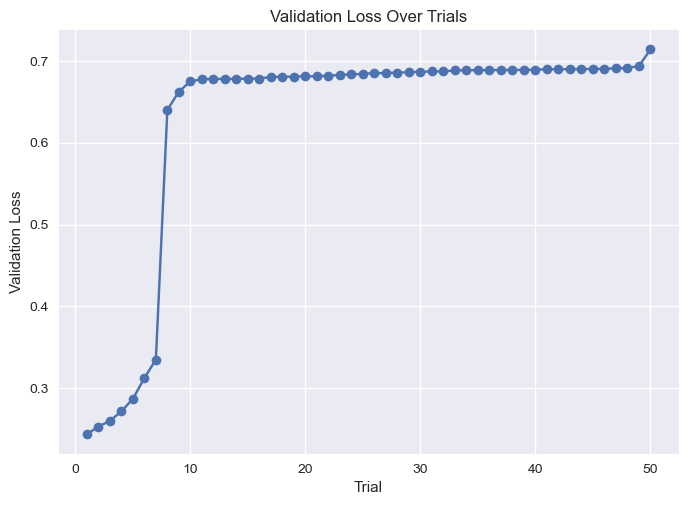

In [99]:
# Get all trials
trials = tuner.oracle.get_best_trials(num_trials=50)

# Extract accuracy scores
accuracies = [trial.metrics.get_best_value('val_loss') for trial in trials]

# Plot
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
plt.xlabel('Trial')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Over Trials')
plt.show()


#### Validation Loss Over Trials
- This graph displays the validation loss of the model across 50 trials during the hyperparameter tuning process. The primary observations are:

   - Initial Decrease: The validation loss decreases significantly during the early trials, indicating that the model is improving as the tuning process selects better hyperparameters.
   - Plateau: After approximately the 10th trial, the validation loss plateaus around 0.3. This suggests that the model has reached a point where further tuning provides minimal improvements, indicating convergence to an optimal set of hyperparameters.
  - Final Increase: A slight increase in validation loss towards the end may indicate that some hyperparameter combinations in the later trials were less effective, reaffirming the stability of the earlier optimal parameters.
- This pattern suggests that the tuning process successfully identified a robust set of hyperparameters that minimized validation loss effectively.

### Generating Predictions of Best Base Model and Comparison with Actual Values
  - In this step, we generate predictions using the best-performing base model and compare these predictions with the actual target values from the test data:

**Generating Predictions:**
 - The model's predictions are generated on the test data.
 - The output of the model is in probabilities, which are then converted to binary values (0 or 1) using a threshold of 0.5.
**Comparison with Actual Values:**
 - The actual values from the test data are extracted and aligned with the predictions.
 - A DataFrame (comparison_df) is created to compare the model's predictions with the actual values side by side.


In [141]:
# Generate predictions using the test data
predictions = best_model.predict(test_generator)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary 0 or 1

# Actual values from the test data
actual = y_test[-len(predictions):]  # Ensure the length matches the predictions

# Combine predictions and actual values into a DataFrame
comparison_df = pd.DataFrame({
    'Predicted': predictions.flatten(),
    'Actual': actual
})

# Display the first few rows of the comparison DataFrame
print(comparison_df)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
     Predicted  Actual
0            0     0.0
1            0     0.0
2            0     0.0
3            0     0.0
4            1     1.0
..         ...     ...
304          0     0.0
305          1     1.0
306          1     0.0
307          0     0.0
308          0     0.0

[309 rows x 2 columns]


- **Output Display:**
  - The first few rows of the comparison DataFrame are displayed, showing how the model's predictions match the actual outcomes.
  - The output demonstrates that the model has accurately predicted several instances, as shown by the alignment of predicted and actual values. This provides an initial view of the model's performance before detailed evaluation.



In [101]:
# Save the best model
best_model.save("best_base_lstm_model.keras")

- the best model is saved for future use or further analysis.

In [143]:
# Launch TensorBoard
%tensorboard --logdir=./logs/lstm_model_1

---

### Model-2)  LSTM with 2 Layers

**Architecture Overview:**

  - The LSTM-2 Layer model introduces an additional layer of LSTM neurons compared to the base single-layer LSTM model. 
  - The architecture is designed to capture more complex patterns and dependencies in the sequential data by allowing information to flow through multiple layers before making a prediction.



- **Differences from the Base Model (Single Layer):**

   - **Deeper Network:**
     - The introduction of a second LSTM layer increases the model's depth, enabling it to learn more abstract and high-level features from the data.
     - In contrast to the single-layer LSTM, which only has one set of LSTM units processing the input data, the two-layer model processes the data twice through separate LSTM layers before making a prediction.
  - **Return Sequences:**
    - The first LSTM layer in this model has return_sequences=True, which means that the output of each time step is fed into the next LSTM layer. This setting is crucial for stacking multiple LSTM layers, as it ensures that the full sequence is passed through each layer.
  - **Dropout Regularization:**
    - Dropout layers are added after each LSTM layer to prevent overfitting by randomly setting a fraction of input units to 0 during training. This enhances the model's generalization ability.

In [30]:
# Step 1: Build the Model with Hyperparameter Tuning
def build_model(hp):
    tf.keras.backend.clear_session()
    
    # Instantiate the model
    model = Sequential()
    
    # Tune the number of units for the first LSTM layer
    hp_units1 = hp.Int('units1', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate for the first LSTM layer
    hp_dropout1 = hp.Float('dropout_rate1', min_value=0.0, max_value=0.5, step=0.1)
    
    # Add the first LSTM layer
    model.add(LSTM(units=hp_units1, input_shape=(lookback, X_train_scaled.shape[1]), 
                   activation='relu', return_sequences=True))
    
    # Add Dropout after the first LSTM layer
    model.add(Dropout(hp_dropout1))
    
    # Tune the number of units for the second LSTM layer
    hp_units2 = hp.Int('units2', min_value=4, max_value=32, step=4)
    
    # Tune the dropout rate for the second LSTM layer
    hp_dropout2 = hp.Float('dropout_rate2', min_value=0.0, max_value=0.5, step=0.1)
    
    # Add the second LSTM layer
    model.add(LSTM(units=hp_units2, activation='relu', return_sequences=False))
    
    # Add Dropout after the second LSTM layer
    model.add(Dropout(hp_dropout2))
    
    # Add output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]), 
                                 epsilon=1e-08, decay=0.0),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model

**Explanation:**

 - **Layer 1 - First LSTM:**
    - **units1:** This parameter defines the number of LSTM units (neurons) in the first layer. The hp.Int function is used to tune this value during hyperparameter optimization, with possible values ranging from 4 to 32 in steps of 4.
   - **return_sequences=True:** This ensures that the output of each time step is passed as input to the next LSTM layer.
- **Layer 2 - First Dropout:**
  - **dropout_rate1:** A tunable dropout rate is applied after the first LSTM layer to prevent overfitting.
- **Layer 3 - Second LSTM:**
  - **units2:** Defines the number of units in the second LSTM layer, similar to the first, but with its own tunable parameters.
  - **return_sequences=False:** This is set to False as it is the final LSTM layer, and we only need the output of the last time step.
- **Layer 4 - Second Dropout:**
  - **dropout_rate2:** Similar to the first dropout layer but applied after the second LSTM layer.
  - **Output Layer:**
    - A dense layer with a single output and a sigmoid activation function is used to predict the probability of the target class.

- **Compilation:**
  - The model is compiled with the Adam optimizer, binary cross-entropy loss, and accuracy, precision, and recall as the evaluation metrics.

- This architecture is more sophisticated than the base model, potentially offering better performance on complex datasets due to its increased depth and ability to capture more nuanced relationships in the data.

#### RandomSearch Tuner for the LSTM 2-Layer Model

In [32]:
# Step 2: Setup RandomSearch Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',  # Use loss as the primary metric
    max_trials=50,  # Maximum number of trials
    directory='./keras',
    project_name='rs_2layer_lstm',  # Change this to distinguish between trials
    overwrite=True
)

#### Callbacks for Early Stopping and TensorBoard for LSTM 2-layer Model

In [33]:
# Step 3: Setup Callbacks for Early Stopping and TensorBoard
log_dir = "./logs/2_layer_lstm"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

# Include the callbacks in the model training
callbacks = [early_stopping, tensorboard_callback]

#### Perform the Hyperparameter Search for LSTM 2-Layer Model
  - In this step, the hyperparameter tuning process is executed using the tuner.search() function. The search is performed over 50 trials, evaluating the model on the validation data to find the best hyperparameter configuration.

In [34]:
# Step 4: Perform the Hyperparameter Search
tuner.search(train_generator, epochs=100, validation_data=test_generator,
             class_weight=class_weight_dict,
             callbacks=callbacks)

Trial 50 Complete [00h 00m 05s]
val_loss: 0.6762955784797668

Best val_loss So Far: 0.31076815724372864
Total elapsed time: 00h 05m 47s


**Results:**
 
 - The best validation loss (val_loss) achieved during the search process was 0.31076815724372864, demonstrating the model's ability to generalize well on unseen data.
The total time taken for the entire hyperparameter search was just under 6 minutes, indicating an efficient tuning process.

#### Retrieve the Best Hyperparameters for Model-2

In [35]:
# Step 5: Retrieve the Best Hyperparameters
best_hbp = tuner.get_best_hyperparameters()[0]
print(best_hbp.values)

{'units1': 20, 'dropout_rate1': 0.0, 'units2': 20, 'dropout_rate2': 0.2, 'learning_rate': 0.001}


**Best Hyperparameters Retrieved:**
 - Units in First LSTM Layer (units1): 20
 - Dropout Rate After First LSTM Layer (dropout_rate1): 0.0 (no dropout applied)
 - Units in Second LSTM Layer (units2): 20
 - Dropout Rate After Second LSTM Layer (dropout_rate2): 0.2 (20% dropout applied)
 - Learning Rate: 0.001

In [36]:
# Display tuning results summary
tuner.results_summary()

Results summary
Results in ./keras/rs_2layer_lstm
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 32 summary
Hyperparameters:
units1: 20
dropout_rate1: 0.0
units2: 20
dropout_rate2: 0.2
learning_rate: 0.001
Score: 0.31076815724372864

Trial 21 summary
Hyperparameters:
units1: 32
dropout_rate1: 0.0
units2: 12
dropout_rate2: 0.4
learning_rate: 0.001
Score: 0.3256916403770447

Trial 10 summary
Hyperparameters:
units1: 20
dropout_rate1: 0.4
units2: 20
dropout_rate2: 0.1
learning_rate: 0.001
Score: 0.32647982239723206

Trial 15 summary
Hyperparameters:
units1: 32
dropout_rate1: 0.2
units2: 24
dropout_rate2: 0.1
learning_rate: 0.001
Score: 0.32763558626174927

Trial 06 summary
Hyperparameters:
units1: 16
dropout_rate1: 0.2
units2: 24
dropout_rate2: 0.0
learning_rate: 0.001
Score: 0.3336203992366791

Trial 04 summary
Hyperparameters:
units1: 4
dropout_rate1: 0.2
units2: 24
dropout_rate2: 0.2
learning_rate: 0.001
Score: 0.5586530566215515

Trial 22 summary
Hyperparame

#### Evaluate the Best LSTM 2-Layer Model on Train and Test Data

In [37]:
# Step 6: Evaluate the Best LSTM 2-Layer Model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(test_generator)

# Evaluate the model on the test data
loss, accuracy, precision, recall = best_model.evaluate(test_generator)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8637 - loss: 0.3115 - precision: 0.7711 - recall: 0.9471  
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8637 - loss: 0.3115 - precision: 0.7711 - recall: 0.9471 
Accuracy: 0.8608
Precision: 0.7610
Recall: 0.9603
F1 Score: 0.8491


**Results on Test data:**
   - **Accuracy:** The model achieved an accuracy of 0.8608 on the test data, meaning approximately 86% of predictions were correct.
  - **Precision:** Precision is 0.7610, indicating that when the model predicted an uptrend (class 1), about 76% of those predictions were correct.
 - **Recall:** The recall is 0.9603, which shows that the model was able to identify 96% of all actual uptrends (class 1) correctly.
 - **F1 Score:** The F1 score, which is the harmonic mean of precision and recall, is 0.8491. This score represents a balance between precision and recall, showing that the model has a good balance of correctly predicting both classes with reasonable precision and recall.

#### Summary of the Best LSTM 2-Layer Model

In [38]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 21, 20)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,901 (26.96 KB)

 Trainable params: 6,901 (26.96 KB)

 Non-trainable params: 0 (0.00 B)

- Summary of the Best LSTM 2-Layer Model
  - The model summary shows the architecture of the best 2-layer LSTM model obtained through hyperparameter tuning. Here’s a brief explanation of each layer:

- First LSTM Layer:
  - This layer has 20 units (neurons) as determined by the hyperparameter tuning.
  - The input shape is (21, 20), indicating that the model uses 21 time steps (lookback period) with 20 features per step.
  - The return_sequences=True parameter ensures that the output of this LSTM layer is passed as a sequence to the next LSTM layer.
- First Dropout Layer:
  - A dropout layer is added after the first LSTM layer to prevent overfitting by randomly setting a fraction of input units to 0 during training.
  - In this case, the dropout rate is 0, indicating that no dropout is applied for this layer.
- Second LSTM Layer:
  - This layer also has 20 units. However, unlike the first LSTM layer, return_sequences=False, meaning it only outputs the final hidden state to the next layer.
  - This layer further processes the sequence data, summarizing it to a single output.
- Second Dropout Layer:
  - Another dropout layer is added after the second LSTM layer with a dropout rate of 0.2, meaning 20% of the units are randomly dropped during training.
- Dense Output Layer:
  - The final layer is a Dense layer with a single unit, using the sigmoid activation function to output a probability between 0 and 1, representing the model's prediction for the target class.

- Total Parameters:

  - The model has 6,901 trainable parameters, which the model learns during training to make accurate predictions.
- This architecture allows the model to capture complex temporal patterns and dependencies in the input data, contributing to its improved performance over a single-layer LSTM model.

In [40]:
# Generate predictions using the test data
predictions = best_model.predict(test_generator)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary 0 or 1

# Actual values from the test data
actual = y_test[-len(predictions):]  # Ensure the length matches the predictions

# Combine predictions and actual values into a DataFrame
comparison_df = pd.DataFrame({
    'Predicted': predictions.flatten(),
    'Actual': actual
})

# Display the first few rows of the comparison DataFrame
print(comparison_df.head(20))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
    Predicted  Actual
0           0     0.0
1           0     0.0
2           0     0.0
3           0     0.0
4           1     1.0
5           0     0.0
6           1     1.0
7           0     0.0
8           1     1.0
9           1     1.0
10          0     0.0
11          1     1.0
12          1     1.0
13          1     0.0
14          0     0.0
15          1     1.0
16          1     1.0
17          1     1.0
18          0     1.0
19          0     0.0


In [41]:
#  Save the best model
best_model.save("best_2_layer_lstm_model.keras")

- Best LSTM 2 layer saved for future use

In [157]:
# Launch TensorBoard
%tensorboard --logdir=./logs/2_layer_lstm

---

### Model-3) LSTM 5-Layers 

**Architecture**

 - The 5-layer LSTM model is a more complex architecture designed to capture deeper and more intricate patterns in time series data. Here's how it works:

- **Layer Structure:** 
  - The model consists of five LSTM layers stacked sequentially. Each layer processes the time-series data step by step, allowing the model to capture both short-term and long-term dependencies.
- **Data Flow:** 
  - The input data flows through each LSTM layer, with each layer's output serving as the input for the next layer.   - The return_sequences parameter is set to True for the first four LSTM layers, which means that each layer outputs a full sequence of data for the next layer to process. The fifth LSTM layer, which is the final one, outputs only the last time step, which is then fed into the dense output layer.
- **Dropout:**
  - Between each LSTM layer, a dropout layer is added to prevent overfitting by randomly setting a fraction of input units to zero at each update during training time. The dropout rate is a tunable hyperparameter.
- **Output Layer:**
  - The final dense layer uses a sigmoid activation function to output a single probability value, which represents the likelihood of the SPY ETF having an upward trend for the next day.
- **Purpose:**
   - This deeper network allows the model to learn more complex patterns in the data, which might not be captured by simpler models like a single-layer LSTM or a two-layer LSTM.

In [ ]:
# Step 1: Build the 5-Layer LSTM Model with Hyperparameter Tuning
def build_model(hp):
    tf.keras.backend.clear_session()
    
    model = Sequential()
    
    # First LSTM Layer
    hp_units1 = hp.Int('units1', min_value=4, max_value=64, step=4)
    hp_dropout1 = hp.Float('dropout_rate1', min_value=0.0, max_value=0.5, step=0.1)
    model.add(LSTM(units=hp_units1, input_shape=(lookback, X_train_scaled.shape[1]), activation='relu', return_sequences=True))
    model.add(Dropout(hp_dropout1))
    
    # Second to Fifth LSTM Layers
    for i in range(2, 6):
        hp_units = hp.Int(f'units{i}', min_value=4, max_value=64, step=4)
        hp_dropout = hp.Float(f'dropout_rate{i}', min_value=0.0, max_value=0.5, step=0.1)
        model.add(LSTM(units=hp_units, activation='relu', return_sequences=True if i < 5 else False))
        model.add(Dropout(hp_dropout))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the Model
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]), epsilon=1e-08, decay=0.0),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model

**Explanation**
  - **Sequential Model:**
    - This line initializes a sequential model where layers are added in a linear stack.
 - **First LSTM Layer:**
    - The number of units and dropout rate for the first LSTM layer are tuned using hyperparameters. This layer is responsible for capturing initial patterns in the time-series data.
- **Second to Fifth LSTM Layers:**
  - A loop is used to add the remaining four LSTM layers, each with tunable units and dropout rates. These layers help the model to learn deeper and more complex features.
- **Output Layer:**
  - The final dense layer produces the binary classification output, predicting whether the SPY ETF will trend upwards.
- **Compilation:** 
  - The model is compiled using the Adam optimizer, with a binary cross-entropy loss function, and it tracks accuracy, precision, and recall as metrics. Hyperparameters for learning rate are also tuned during training.

- This architecture allows the model to leverage the depth of the LSTM layers to better understand complex patterns in the time series data, potentially leading to more accurate predictions

#### RandomSearch Tuner for LSTM 5 layers Model

In [44]:
# Step 2: Setup RandomSearch Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',  # Use loss as the primary metric
    max_trials=50,  # Maximum number of trials
    directory='./keras',
    project_name='rs_5layer_lstm',  #to distinguish between trials
    overwrite=True
)

#### Callbacks for Early Stopping and Tensorboard

In [45]:
# Setup Callbacks for Early Stopping and TensorBoard
log_dir = "./logs/5_layer_lstm"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

callbacks = [early_stopping, tensorboard_callback]

#### Hyperparameter Search with RandomSearch Tuner

In [46]:
# Step 3: Perform the Hyperparameter Search
tuner.search(train_generator, epochs=100, validation_data=test_generator, class_weight=class_weight_dict, callbacks=callbacks)

Trial 50 Complete [00h 00m 17s]
val_loss: 0.6621342301368713

Best val_loss So Far: 0.2610277831554413
Total elapsed time: 00h 17m 02s


**Results:**
  - Best Validation Loss: The best val_loss achieved so far is 0.2610, indicating how well the model generalizes to the validation data.
 - Total Time: The total elapsed time for completing all 50 trials is approximately 17 minutes and 2 seconds, showcasing the efficiency of the hyperparameter tuning process.
- This step is crucial in optimizing the model's performance by finding the best set of hyperparameters, which directly impacts the model's ability to predict the SPY ETF's trend with high accuracy.

In [47]:
# Step 4: Retrieve the Best Hyperparameters
best_hbp = tuner.get_best_hyperparameters()[0]
print(best_hbp.values)

{'units1': 64, 'dropout_rate1': 0.30000000000000004, 'units2': 48, 'dropout_rate2': 0.0, 'units3': 32, 'dropout_rate3': 0.2, 'units4': 8, 'dropout_rate4': 0.0, 'units5': 48, 'dropout_rate5': 0.30000000000000004, 'learning_rate': 0.001}


- The hyperparameter tuning process identified the following optimal set of hyperparameters for the 5-layer LSTM model:

- First LSTM Layer:
  - Units: 64
  - Dropout Rate: 0.3
- Second LSTM Layer:
  - Units: 48
  - Dropout Rate: 0.0
- Third LSTM Layer:
  - Units: 32
  - Dropout Rate: 0.2
- Fourth LSTM Layer:
  - Units: 8
  - Dropout Rate: 0.0
- Fifth LSTM Layer:
  - Units: 48
  - Dropout Rate: 0.3
- Learning Rate: 0.001


In [48]:
# Display tuning results summary
tuner.results_summary()

Results summary
Results in ./keras/rs_5layer_lstm
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 29 summary
Hyperparameters:
units1: 64
dropout_rate1: 0.30000000000000004
units2: 48
dropout_rate2: 0.0
units3: 32
dropout_rate3: 0.2
units4: 8
dropout_rate4: 0.0
units5: 48
dropout_rate5: 0.30000000000000004
learning_rate: 0.001
Score: 0.2610277831554413

Trial 38 summary
Hyperparameters:
units1: 52
dropout_rate1: 0.4
units2: 4
dropout_rate2: 0.2
units3: 16
dropout_rate3: 0.2
units4: 48
dropout_rate4: 0.1
units5: 16
dropout_rate5: 0.30000000000000004
learning_rate: 0.001
Score: 0.2615254819393158

Trial 13 summary
Hyperparameters:
units1: 12
dropout_rate1: 0.1
units2: 64
dropout_rate2: 0.4
units3: 4
dropout_rate3: 0.4
units4: 24
dropout_rate4: 0.30000000000000004
units5: 20
dropout_rate5: 0.1
learning_rate: 0.001
Score: 0.34811753034591675

Trial 12 summary
Hyperparameters:
units1: 64
dropout_rate1: 0.0
units2: 16
dropout_rate2: 0.4
units3: 24
dropout_rate3: 0.1


#### Evaluate the Best 5-Layer LSTM Model

In [49]:
# Evaluate the Best Model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(test_generator)

# Evaluate the model on the test data
loss, accuracy, precision, recall = best_model.evaluate(test_generator)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8654 - loss: 0.2609 - precision: 0.7526 - recall: 0.9978  
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8654 - loss: 0.2609 - precision: 0.7526 - recall: 0.9978
Accuracy: 0.8673
Precision: 0.7576
Recall: 0.9921
F1 Score: 0.8591


**Evaluation of the Best 5-Layer LSTM Model**

 - **Accuracy: 0.8673**
   - Accuracy indicates the proportion of correct predictions made by the model out of all predictions. With an accuracy of approximately 86.7%, the model correctly predicts the direction of the SPY ETF's trend most of the time. 
 - **Precision: 0.7576**
   - Precision measures the accuracy of the positive predictions made by the model. Specifically, it tells us the percentage of predictions that were actually positive (uptrend) out of all predictions that the model classified as positive. A precision of 75.8% indicates that when the model predicts an uptrend, it's correct about 75.8% of the time. While this is strong, there is some room for improvement to reduce false positives.
 - **Recall: 0.9921**
   - Recall, also known as sensitivity or true positive rate, measures the model's ability to correctly identify all actual positives (uptrends). With a recall of 99.2%, the model is highly effective at capturing nearly all of the true uptrends in the data. This high recall is crucial for financial models where missing an uptrend could lead to lost opportunities.
- **F1 Score: 0.8591**
   - The F1 Score is the harmonic mean of precision and recall, providing a single metric that balances both. With an F1 score of 85.9%, the model achieves a good balance between precision and recall, making it reliable for predicting uptrends in the SPY ETF. 

#### Model Summary of Best 5-layer LSTM model

In [50]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 21, 64)         │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 21, 48)         │        21,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 21, 32)         │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 21, 8)          │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 21, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 48)             │        10,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,153 (262.32 KB)

 Trainable params: 67,153 (262.32 KB)

 Non-trainable params: 0 (0.00 B)

- The model summary for the best 5-layer LSTM model provides an overview of the architecture, detailing each layer's type, output shape, and the number of parameters. Here’s a breakdown:

- **LSTM Layers:**
  - **First LSTM Layer:** The first layer has 64 units, which captures the most immediate and foundational patterns in the data. It has 22,784 trainable parameters, which include weights, biases, and the connections between time steps.
  - **Second to Fifth LSTM Layers:** Each subsequent LSTM layer (with 48, 32, 8, and 48 units, respectively) adds complexity to the model, allowing it to learn deeper and more intricate patterns. The number of parameters decreases with each layer, indicating a reduction in the number of units and connections.
- **Dropout Layers:**
  - Dropout layers are placed after each LSTM layer to help prevent overfitting. These layers randomly drop a fraction of the units during training, ensuring the model generalizes better to unseen data.
- **Dense Layer:**
  - The final dense layer, with a single unit and sigmoid activation, produces the binary output (predicting the uptrend or no uptrend for the SPY ETF). This layer synthesizes all the information processed by the preceding LSTM layers.
- **Total Parameters:**
  - The model has a total of 67,153 parameters, all of which are trainable. These parameters are adjusted during training to minimize the loss function, improving the model's predictive performance.

- In summary, the 5-layer LSTM model is more complex than the previous models, with multiple LSTM layers allowing it to capture various levels of temporal patterns. This complexity helps in making more accurate predictions, as indicated by the performance metrics.








#### Generating Prediction of Best 5-layer Model and compare with Actual

In [52]:
# Generate predictions using the test data
predictions = best_model.predict(test_generator)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary 0 or 1

# Actual values from the test data
actual = y_test[-len(predictions):]  # Ensure the length matches the predictions

# Combine predictions and actual values into a DataFrame
comparison_df = pd.DataFrame({
    'Predicted': predictions.flatten(),
    'Actual': actual
})

# Display the first few rows of the comparison DataFrame
print(comparison_df.head(20))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
    Predicted  Actual
0           1     0.0
1           0     0.0
2           0     0.0
3           0     0.0
4           1     1.0
5           0     0.0
6           1     1.0
7           0     0.0
8           1     1.0
9           1     1.0
10          0     0.0
11          1     1.0
12          1     1.0
13          1     0.0
14          0     0.0
15          1     1.0
16          1     1.0
17          1     1.0
18          1     1.0
19          0     0.0


In [56]:
# Save the best model
best_model.save("best_5_layer_lstm_model.keras")

- Best 5 layer LSTM model was saved for future use.

In [156]:
#Launch TensorBoard
%tensorboard --logdir=./logs/5_layer_lstm

---

### Model-4) GRU Model 

 - The Gated Recurrent Unit (GRU) is a type of recurrent neural network (RNN) that is often compared to the Long Short-Term Memory (LSTM) network. 
 - GRUs are particularly known for their simplicity and effectiveness in capturing temporal dependencies in sequential data. 
 - They have fewer parameters than LSTMs, which can make them faster to train while still retaining a strong capacity for learning long-term dependencies.

**Architecture Overview:**

 - **Input:**
   - The input to the GRU model is a sequence of data, specifically designed to handle time-series data like our SPY ETF dataset. 
   - The input shape for the GRU model is (lookback, number_of_features), where lookback represents the number of previous time steps (in our case, 21 days), and number_of_features corresponds to the number of features in the dataset.

 - **GRU Layers:**
   - **Gated Mechanism:** The GRU architecture utilizes gating mechanisms (reset and update gates) that control the flow of information. 
     - This helps in deciding which information to retain from the previous time steps and which to discard. Unlike LSTM, GRU has a simpler structure with fewer gates, making it faster and more efficient.
   - **Activation:** Typically, relu is used as the activation function in GRUs, which introduces non-linearity and allows the model to learn more complex patterns.
- **Output Layer:**
  - The final output layer is a dense layer with a single neuron and a sigmoid activation function, producing a binary classification (uptrend or no uptrend).
 
- **Speciality of GRU Compared to LSTM:**

  - **Efficiency:** GRUs generally have fewer parameters compared to LSTMs, which makes them faster to train and potentially less prone to overfitting on smaller datasets.
  - **Simpler Architecture:** The GRU architecture is less complex than LSTM as it does not have separate forget, input, and output gates. Instead, it combines these into a single update gate, which reduces computational load.
  - **Performance:** GRUs often perform as well as LSTMs on many tasks, especially when the sequence lengths are not too long. However, for very long sequences, LSTMs might have an advantage due to their more intricate gating mechanisms.

In [61]:
# Step 1: Build the GRU Model with Hyperparameter Tuning
def build_model(hp):
    tf.keras.backend.clear_session()
    
    # Instantiate the model
    model = Sequential()
    
    # Tune the number of units for the first GRU layer
    hp_units1 = hp.Int('units1', min_value=4, max_value=64, step=4)
    # Tune the dropout rate for the first GRU layer
    hp_dropout1 = hp.Float('dropout_rate1', min_value=0.0, max_value=0.5, step=0.1)
    
    # Add the first GRU layer
    model.add(GRU(units=hp_units1, input_shape=(lookback, X_train_scaled.shape[1]), 
                  activation='relu', return_sequences=True))
    # Add Dropout after the first GRU layer
    model.add(Dropout(hp_dropout1))
    
    # Add a second GRU layer
    hp_units2 = hp.Int('units2', min_value=4, max_value=64, step=4)
    hp_dropout2 = hp.Float('dropout_rate2', min_value=0.0, max_value=0.5, step=0.1)
    model.add(GRU(units=hp_units2, activation='relu', return_sequences=False))
    model.add(Dropout(hp_dropout2))
    
    # Add output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]), 
                                 epsilon=1e-08, decay=0.0),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model


**Explanation of the Code:**

 - **GRU Layers:**
   - Two GRU layers are added, each with tunable units and dropout rates. The first GRU layer returns sequences, allowing the second GRU layer to process the entire sequence.
 - **Dropout Layers:**
   - Dropout is applied after each GRU layer to prevent overfitting by randomly dropping units during training.
 - **Output Layer:** The dense layer with a sigmoid activation function provides a binary classification output.
   - Hyperparameter Tuning: The hyperparameters like the number of units in each GRU layer, dropout rates, and learning rates are tuned using the Keras Tuner to find the best configuration for the model.
- This GRU model is specifically designed to capture the sequential dependencies in the SPY ETF data, and with the proper tuning, it can be a powerful tool for time-series prediction.
 - The simplicity of the GRU architecture allows it to be more efficient in terms of computational resources compared to LSTM, while still maintaining strong performance in capturing temporal patterns.

#### RandomSearch Tuner for GRU Model

In [62]:
# Step 2: Setup RandomSearch Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',  # Use loss as the primary metric
    max_trials=50,  # Maximum number of trials
    directory='./keras',
    project_name='random_search_gru',  # Change this to distinguish between trials
    overwrite=True
)


#### Callbacks for GRU Model

In [63]:
# Step 3: Setup Callbacks for Early Stopping and TensorBoard
log_dir = "./logs/gru_model"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

# Include the callbacks in the model training
callbacks = [early_stopping, tensorboard_callback]


#### Hyper Parameter Random Search for GRU Model
- In this step, we perform the hyperparameter search for the GRU model using Keras Tuner's RandomSearch method. The goal is to identify the optimal combination of hyperparameters that minimize the validation loss on the test data.


In [64]:
# Step 4: Perform the Hyperparameter Search
tuner.search(train_generator, epochs=100, validation_data=test_generator,
             class_weight=class_weight_dict,
             callbacks=callbacks)

Trial 50 Complete [00h 00m 31s]
val_loss: 0.6874955296516418

Best val_loss So Far: 0.20347130298614502
Total elapsed time: 00h 25m 08s


#### Explanations: 
   - **Trial Process:**
      - A total of 50 trials were conducted, with each trial testing a different combination of hyperparameters (such as the number of units in each GRU layer, dropout rates, and learning rates).
      - Each trial involves training the GRU model on the training data (train_generator) and evaluating it on the validation data (test_generator).
   - **Validation Loss:**
     - The primary metric used to evaluate the performance of the model during tuning is val_loss, which represents the loss on the validation dataset.
     - After 50 trials, the best validation loss achieved is 0.20347130298614502. This indicates that this specific combination of hyperparameters resulted in the most accurate predictions on the validation data.
   - **Elapsed Time:**
     - The entire tuning process took approximately 25 minutes and 8 seconds to complete all 50 trials.

#### Retrieve the Best Hyperparameters for GRU Model

In [65]:
# Step 5: Retrieve the Best Hyperparameters
best_hbp = tuner.get_best_hyperparameters()[0]
print(best_hbp.values)

{'units1': 24, 'dropout_rate1': 0.30000000000000004, 'units2': 36, 'dropout_rate2': 0.0, 'learning_rate': 0.001}


- **Best Hyperparameters:**
   - units1: 24
   - dropout_rate1: 0.3
   - units2: 36
   - dropout_rate2: 0.0
   - learning_rate: 0.001
- **Explanation:**
   - units1 and units2: These define the number of units (neurons) in the first and second GRU layers, respectively. The model performed best with 24 units in the first layer and 36 units in the second layer.
  - dropout_rate1 and dropout_rate2: Dropout is a regularization technique to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training. The first GRU layer has a dropout rate of 0.3 (meaning 30% of the units are dropped), while the second layer does not apply dropout (0.0).
  - learning_rate: The learning rate controls the step size in updating the model weights during training. A learning rate of 0.001 was found to be the most effective in minimizing the validation loss during the tuning process.

In [66]:
# Display tuning results summary
tuner.results_summary()


Results summary
Results in ./keras/random_search_gru
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 15 summary
Hyperparameters:
units1: 24
dropout_rate1: 0.30000000000000004
units2: 36
dropout_rate2: 0.0
learning_rate: 0.001
Score: 0.20347130298614502

Trial 08 summary
Hyperparameters:
units1: 44
dropout_rate1: 0.2
units2: 16
dropout_rate2: 0.1
learning_rate: 0.001
Score: 0.23656423389911652

Trial 42 summary
Hyperparameters:
units1: 64
dropout_rate1: 0.1
units2: 64
dropout_rate2: 0.2
learning_rate: 0.001
Score: 0.2381349354982376

Trial 16 summary
Hyperparameters:
units1: 36
dropout_rate1: 0.1
units2: 36
dropout_rate2: 0.0
learning_rate: 0.001
Score: 0.24368233978748322

Trial 07 summary
Hyperparameters:
units1: 12
dropout_rate1: 0.2
units2: 60
dropout_rate2: 0.0
learning_rate: 0.01
Score: 0.274105042219162

Trial 12 summary
Hyperparameters:
units1: 44
dropout_rate1: 0.1
units2: 24
dropout_rate2: 0.2
learning_rate: 0.001
Score: 0.2976452112197876

Trial 24 s

#### Evaluate the Best GRU Model

In [67]:
# Step 6: Evaluate the Best GRU Model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(test_generator)

# Evaluate the model on the test data
loss, accuracy, precision, recall = best_model.evaluate(test_generator)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8892 - loss: 0.1890 - precision: 0.8713 - recall: 0.8552  
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8892 - loss: 0.1890 - precision: 0.8713 - recall: 0.8552 
Accuracy: 0.8900
Precision: 0.8898
Recall: 0.8333
F1 Score: 0.8607


**Output Metrics on Test Data:**

- Accuracy: 0.8900
- Precision: 0.8898
- Recall: 0.8333
- F1 Score: 0.8607

- **Explanation:**
  - Accuracy: The model correctly predicted the uptrend or downtrend 89.00% of the time. This indicates strong overall performance.
  - Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. A precision of 0.8898 means that about 89% of the times when the model predicted an uptrend, it was correct.
  - Recall: Recall (or Sensitivity) is the ratio of correctly predicted positive observations to all observations in the actual class. A recall of 0.8333 means the model correctly identified about 83% of the actual uptrends.
  - F1 Score: The F1 Score is the weighted average of Precision and Recall. The F1 Score of 0.8607 reflects the balance between precision and recall, indicating that the model performs well in identifying uptrends with a reasonable trade-off between false positives and false negatives.

#### Summary of the best GRU Model

In [68]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 21, 24)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 36)             │         6,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            37 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,333 (40.36 KB)

 Trainable params: 10,333 (40.36 KB)

 Non-trainable params: 0 (0.00 B)


- **GRU Layers:**
   - The first GRU layer has 24 units with a dropout rate of 0.3. This layer processes the input sequence and passes the information to the next GRU layer.
  - The second GRU layer has 36 units with no dropout. This layer processes the output of the first GRU layer to further refine the temporal patterns identified in the input sequence.
- **Dropout Layers:**
  - Dropout layers are placed after each GRU layer to prevent overfitting by randomly dropping a fraction of the units during training. The first dropout layer has a rate of 0.3, which means 30% of the units are dropped during each update.
- **Dense Layer:**
  - The model ends with a dense layer containing a single unit with a sigmoid activation function. This layer outputs a probability score that determines the predicted class (uptrend or downtrend).
- **Model Complexity:**
   - The total number of trainable parameters in this model is 10,333. This relatively low number of parameters indicates that the model is not overly complex, which can help in reducing overfitting while still capturing the essential patterns in the data.


#### Generating Prediction of Best GRU model and comparing with actual

In [70]:
# Generate predictions using the test data
predictions = best_model.predict(test_generator)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary 0 or 1

# Actual values from the test data
actual = y_test[-len(predictions):]  # Ensure the length matches the predictions

# Combine predictions and actual values into a DataFrame
comparison_df = pd.DataFrame({
    'Predicted': predictions.flatten(),
    'Actual': actual
})

# Display the first few rows of the comparison DataFrame
print(comparison_df.head(20))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    Predicted  Actual
0           1     0.0
1           0     0.0
2           0     0.0
3           0     0.0
4           1     1.0
5           0     0.0
6           1     1.0
7           0     0.0
8           1     1.0
9           1     1.0
10          0     0.0
11          0     1.0
12          1     1.0
13          0     0.0
14          0     0.0
15          1     1.0
16          0     1.0
17          1     1.0
18          1     1.0
19          0     0.0


In [71]:
#Save the best model
best_model.save("best_gru_model.keras")

- Best GRU model saved for future use

In [155]:
#Launch TensorBoard
%tensorboard --logdir=./logs/gru_model

---

### Model-5) LSTM + CNN Hybrid (Conv1D) Model

**Architecture Explanation:**

  - The LSTM + CNN Hybrid model is designed to leverage the strengths of both Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks. This hybrid model is particularly effective for time-series forecasting because it combines the ability of CNNs to capture local, spatial patterns with the power of LSTM networks to model temporal dependencies.
  
- **Transition to Functional API:**
   - In this LSTM + CNN hybrid model, the Functional API is used instead of the Sequential API.
   - The LSTM + CNN model is more complex than the previous models. The Conv1D layer processes the input data first, and its output is then passed to an LSTM layer. The Functional API is well-suited for handling this kind of data flow, where the output of one branch (the Conv1D layer) needs to be passed to another branch (the LSTM layer) before reaching the output layer.

- **Components of the Architecture:**

  - **Input Layer:**
    - Shape: The input shape is (lookback, X_train_scaled.shape[1]). Here, lookback is the sequence length, representing the number of past time steps the model will look at, and X_train_scaled.shape[1] is the number of features in each time step.
    - Purpose: This layer takes in sequences of data, each of which consists of multiple time steps and features, and passes it on to subsequent layers for processing.
  - **CNN Layer (Conv1D + MaxPooling1D):**
    - Conv1D Layer:
      - Filters: Filters in a convolutional layer are essentially the feature detectors. The number of filters defines how many different patterns the layer will try to learn from the data.
      - Kernel Size: The kernel size determines the width of the convolutional window. It specifies how many time steps will be considered simultaneously when the filter is sliding over the data.
      - Activation Function: ReLU is used to introduce non-linearity, allowing the model to learn complex patterns.
    - MaxPooling1D Layer:
      - Pool Size: After convolution, max-pooling reduces the dimensionality of the output by selecting the maximum  value in a specific window, thereby focusing on the most significant features detected by the filters.
      - Purpose: The CNN layer is used to extract high-level features from the input sequence. It looks for patterns within short subsequences of the input data, capturing local dependencies.

  - **LSTM Layer:**
    - Units: The number of LSTM units is tunable. These units represent the memory cells of the LSTM, which help in capturing and retaining information over time.
    - Return Sequences: The return_sequences parameter is set to False, meaning the LSTM layer only returns the output for the last time step, which is then passed to the next layer.
    - Activation Function: ReLU is again used to introduce non-linearity.
    - Purpose: The LSTM layer processes the high-level features extracted by the CNN layer. It captures long-term dependencies in the data, enabling the model to understand how the sequence of events unfolds over time.
  - **Dropout Layer:**
     - Dropout Rate: Dropout is a regularization technique where a certain percentage of units are randomly dropped during training. This prevents the model from overfitting to the training data.
     - Purpose: The dropout layer helps in generalizing the model by reducing overfitting, making it more robust to new, unseen data.
 - **Output Layer:**
    - Dense Layer: The output layer is a fully connected layer with a single unit. It uses a sigmoid activation function to output a probability score between 0 and 1.
    - Purpose: This layer generates the final prediction. Since the task is binary classification (predicting an uptrend or downtrend), the sigmoid function is ideal as it outputs a probability that the next time step will be an uptrend.
 - **Model Compilation:**
    - Optimizer: The Adam optimizer is used for training, with a tunable learning rate.
    - Loss Function: Binary cross-entropy is used as the loss function, suitable for binary classification tasks.
- Metrics: The model’s performance is evaluated using accuracy, precision, and recall, which provide insights into how well the model is making predictions.


In [73]:
# Step 1: Build the LSTM + CNN Model with Hyperparameter Tuning
def build_model(hp):
    tf.keras.backend.clear_session()
    
    # Input Layer
    inputs = Input(shape=(lookback, X_train_scaled.shape[1]))
    
    # CNN Layer
    hp_filters = hp.Int('filters', min_value=16, max_value=64, step=16)
    hp_kernel_size = hp.Choice('kernel_size', values=[2, 3, 4])
    hp_pool_size = hp.Choice('pool_size', values=[2, 3])
    x = Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=hp_pool_size)(x)
    
    # LSTM Layer
    hp_units = hp.Int('units', min_value=4, max_value=32, step=4)
    x = LSTM(units=hp_units, activation='relu', return_sequences=False)(x)
    
    # Dropout Layer
    hp_dropout = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    x = Dropout(hp_dropout)(x)
    
    # Output Layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Define the model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]), 
                                 epsilon=1e-08, decay=0.0),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model

#### Setup RandomSearch Tuner for LSTM + CNN Hybrid Model
   - In this step, we set up the RandomSearch tuner from the Keras Tuner library, which will be used to find the best hyperparameters for the LSTM + CNN hybrid model.

In [76]:
# Step 2: Setup RandomSearch Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',  # loss as the primary metric
    max_trials=50,  # Maximum number of trials
    directory='./keras',
    project_name='rs_lstm_cnn', 
    overwrite=True
)

#### Callbacks for LSTM + CNN Model

In [77]:
# Step 3: Setup Callbacks for Early Stopping and TensorBoard
log_dir = "./logs/lstm_cnn"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

In [78]:
# Include the callbacks in the model training
callbacks = [early_stopping, tensorboard_callback]

#### Perform the Hyperparameter Search
   - In this step, the hyperparameter search is conducted using the RandomSearch tuner, which iterates through different combinations of hyperparameters to find the most effective configuration for our LSTM + CNN hybrid model.    - This process is aimed at minimizing the validation loss (val_loss) to enhance the model's ability to generalize to unseen data.

In [79]:
# Step 4: Perform the Hyperparameter Search
tuner.search(train_generator, epochs=100, validation_data=test_generator,
             class_weight=class_weight_dict,
             callbacks=callbacks)

Trial 50 Complete [00h 00m 23s]
val_loss: 0.6911958456039429

Best val_loss So Far: 0.31274592876434326
Total elapsed time: 00h 14m 56s


- **Output Interpretation:**

  - Trial 50 Complete val_loss: 0.6911958456039429:
     - This line indicates that the 50th trial has finished, and the validation loss for this specific trial is 0.6912.
  - Best val_loss So Far: 0.31274592876434326:
    - Among all the trials, the best validation loss achieved is 0.3127. This model configuration will be considered the best and will be used in subsequent steps.

#### Retrieve the Best Hyperparameters
   - In this step, we retrieve the best hyperparameters that were found during the hyperparameter search conducted in the previous step. The goal is to identify the optimal configuration of the model that achieved the lowest validation loss.

In [80]:
# Step 5: Retrieve the Best Hyperparameters
best_hbp = tuner.get_best_hyperparameters()[0]
print(best_hbp.values)

{'filters': 48, 'kernel_size': 4, 'pool_size': 2, 'units': 12, 'dropout_rate': 0.2, 'learning_rate': 0.001}


- filters: The best number of filters for the Conv1D layer was found to be 48. Filters in CNN layers are used to detect various features in the input data, such as patterns or trends in time series data.
- kernel_size: The optimal kernel size for the Conv1D layer is 4. The kernel size defines the length of the filter, which determines how many time steps are considered together when detecting patterns.
- pool_size: The best pool size for the MaxPooling1D layer is 2. Pooling helps in downsampling the output from the Conv1D layer, reducing the dimensionality and computation required in subsequent layers.
- units: The number of units in the LSTM layer following the CNN layer was determined to be 12. These units represent the LSTM memory cells that capture temporal dependencies in the time series data.
- dropout_rate: The dropout rate is set at 0.2. Dropout is a regularization technique that helps prevent overfitting by randomly dropping a fraction of units during training.
- learning_rate: The learning rate for the optimizer was found to be 0.001. The learning rate controls how much the model's weights are adjusted in response to the gradient calculated during training.


In [81]:
# Display tuning results summary
tuner.results_summary()

Results summary
Results in ./keras/rs_lstm_cnn
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 40 summary
Hyperparameters:
filters: 48
kernel_size: 4
pool_size: 2
units: 12
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.31274592876434326

Trial 39 summary
Hyperparameters:
filters: 32
kernel_size: 3
pool_size: 2
units: 24
dropout_rate: 0.30000000000000004
learning_rate: 0.001
Score: 0.3178774416446686

Trial 11 summary
Hyperparameters:
filters: 48
kernel_size: 3
pool_size: 2
units: 28
dropout_rate: 0.30000000000000004
learning_rate: 0.001
Score: 0.319101482629776

Trial 20 summary
Hyperparameters:
filters: 48
kernel_size: 4
pool_size: 2
units: 24
dropout_rate: 0.0
learning_rate: 0.001
Score: 0.3396197557449341

Trial 30 summary
Hyperparameters:
filters: 64
kernel_size: 4
pool_size: 2
units: 24
dropout_rate: 0.0
learning_rate: 0.0001
Score: 0.34410375356674194

Trial 36 summary
Hyperparameters:
filters: 32
kernel_size: 2
pool_size: 2
units: 28
dropout_rate: 0.3

#### Evaluate the Best LSTM+CNN Model

In [82]:
# Step 6: Evaluate the Best LSTM+CNN Model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(test_generator)

# Evaluate the model on the test data
loss, accuracy, precision, recall = best_model.evaluate(test_generator)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8440 - loss: 0.3277 - precision: 0.7586 - recall: 0.9043  
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8440 - loss: 0.3277 - precision: 0.7586 - recall: 0.9043 
Accuracy: 0.8544
Precision: 0.7682
Recall: 0.9206
F1 Score: 0.8375


**Evaluation Metrics:**

 - The model's performance is evaluated using several key metrics:

  - **Accuracy:** Measures the proportion of correct predictions (both uptrends and downtrends) made by the model out of the total predictions. An accuracy of 0.8544 indicates that approximately 85.44% of the predictions were correct.
  - **Precision:** Focuses on the model’s ability to correctly identify positive instances (uptrends) among the instances it predicted as positive. A precision score of 0.7682 suggests that around 76.82% of the uptrends predicted by the model were actually uptrends.
  - **Recall:** Also known as sensitivity, recall measures the model’s ability to identify all actual positive instances (uptrends). A recall score of 0.9206 indicates that the model successfully identified 92.06% of the actual uptrends in the test data.
  - **F1 Score:** The F1 score is the harmonic mean of precision and recall, providing a single metric that balances both. The F1 score of 0.8375 reflects the model's overall performance in terms of precision and recall.

#### Summary of Best LSTM + CNN Model

In [83]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 18, 48)         │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 48)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 12)             │         2,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,597 (29.68 KB)

 Trainable params: 7,597 (29.68 KB)

 Non-trainable params: 0 (0.00 B)

- Input Layer (InputLayer)
  - Output Shape: (None, 21, 24)

  - The input layer expects data with a shape of 21 time steps (lookback period) and 24 features. The None dimension represents the batch size, which can vary during training and inference.
- Convolutional Layer (Conv1D)
  - Output Shape: (None, 18, 48)
  - Parameters: 4,656
  
  - The Conv1D layer applies 48 filters of size 4 (as determined by the hyperparameter tuning) across the input sequence, learning to recognize spatial hierarchies and patterns within the data. The convolution operation reduces the time dimension from 21 to 18.
- Pooling Layer (MaxPooling1D)
  - Output Shape: (None, 9, 48)

  - The MaxPooling1D layer reduces the dimensionality of the data by taking the maximum value over a pool size of 2, further compressing the time dimension from 18 to 9. This helps reduce the model complexity and prevent overfitting.
- LSTM Layer (LSTM)
  - Output Shape: (None, 12)
  - Parameters: 2,928

  - The LSTM layer, with 12 units, processes the output of the convolutional layers, capturing the temporal dependencies in the sequence data. The output is a sequence of 12 units representing the learned temporal patterns.
- Dropout Layer (Dropout)
  - Output Shape: (None, 12)

  - The Dropout layer randomly drops 20% of the units during training, as determined by the best hyperparameters. This helps prevent the model from overfitting by ensuring it does not rely too heavily on any single feature.
- Dense Layer (Dense)
  - Output Shape: (None, 1)
  - Parameters: 13

  - The Dense layer serves as the output layer with a single unit and a sigmoid activation function. It outputs a probability between 0 and 1, representing the model’s prediction of the SPY ETF's uptrend.

#### Generate Predictions of best LSTM + CNN model and compare with actual

In [85]:
# Generate predictions using the test data
predictions = best_model.predict(test_generator)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary 0 or 1

# Actual values from the test data
actual = y_test[-len(predictions):]  # Ensure the length matches the predictions

# Combine predictions and actual values into a DataFrame
comparison_df = pd.DataFrame({
    'Predicted': predictions.flatten(),
    'Actual': actual
})

# Display the first few rows of the comparison DataFrame
print(comparison_df.head(20))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
    Predicted  Actual
0           0     0.0
1           0     0.0
2           0     0.0
3           0     0.0
4           1     1.0
5           1     0.0
6           1     1.0
7           0     0.0
8           1     1.0
9           1     1.0
10          0     0.0
11          0     1.0
12          1     1.0
13          1     0.0
14          0     0.0
15          1     1.0
16          1     1.0
17          1     1.0
18          1     1.0
19          0     0.0


In [86]:
#Save the best model
best_model.save("best_lstm_cnn_model.keras") 

- Best LSTM+CNN model saved for future use.

In [154]:
#Launch TensorBoard
%tensorboard --logdir=./logs/lstm_cnn

---

### Step-7) Model Evaluation

### 7.1) Model Evaluation by Evaluation Metrics

- **Loading and Evaluating the Saved Models**
  - After saving the best models during the hyperparameter tuning process, we now proceed to load these models and evaluate their performance using various classification metrics. The purpose of this evaluation is to compare how each model performs on the test dataset.

- **Functionality Overview:**

  - Model Loading: We load the saved models using the load_model function from TensorFlow.
  - Metrics Calculation: We calculate key performance metrics such as accuracy, F1 score, precision, recall, and additional metrics like True Positive Rate (TPR), True Negative Rate (TNR), False Positive Rate (FPR), and False Negative Rate (FNR).
  - Adjusting Test Labels: The test labels (y_test) are adjusted to match the length of predictions (y_pred) generated by each model.
  - Performance Storage: We store the calculated metrics in a dictionary and convert it into a DataFrame for easy comparison.

### Metrics Overview:

### Accuracy:
Accuracy is the ratio of correctly predicted observations to the total observations. It gives an overall view of how well the model is performing, but it might not be enough when dealing with imbalanced data.

**Formula:**

$$
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
$$

#### F1 Score:
- The F1 score is the weighted average of Precision and Recall. It considers both false positives and false negatives, making it a more comprehensive metric, especially when dealing with imbalanced classes.

**Formula:**

$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

#### Precision:
- Precision is the ratio of correctly predicted positive observations to the total predicted positives. High precision relates to a low false positive rate.

**Formula:**

$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

#### Recall (Sensitivity or True Positive Rate - TPR):
- Recall is the ratio of correctly predicted positive observations to all observations in the actual class. High recall indicates that the model successfully captures most of the actual positives.

**Formula:**

$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

#### True Positive Rate (TPR):
- Also known as Recall, it measures the proportion of actual positives that are correctly identified by the model.

#### True Negative Rate (TNR):
- TNR is the ratio of correctly predicted negative observations to all observations in the actual negative class.

**Formula:**

$$
\text{TNR} = \frac{\text{TN}}{\text{TN} + \text{FP}}
$$

#### False Positive Rate (FPR):
- FPR is the ratio of incorrectly predicted positive observations to all actual negatives. A lower FPR is desirable.

**Formula:**

$$
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
$$

#### False Negative Rate (FNR):
- FNR is the ratio of incorrectly predicted negative observations to all actual positives. A lower FNR is desirable.

**Formula:**

$$
\text{FNR} = \frac{\text{FN}}{\text{FN} + \text{TP}}
$$


In [105]:
# Loading the saved models
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Function to calculate TPR, TNR, FPR, FNR
def calculate_tpr_tnr_fpr_fnr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    tpr = tp / (tp + fn)  # True Positive Rate (Sensitivity, Recall)
    tnr = tn / (tn + fp)  # True Negative Rate (Specificity)
    fpr = fp / (fp + tn)  # False Positive Rate
    fnr = fn / (fn + tp)  # False Negative Rate

    return tpr, tnr, fpr, fnr

# Load the best models
best_base_lstm_model = load_model("best_base_lstm_model.keras")
best_2_layer_lstm_model = load_model("best_2_layer_lstm_model.keras")
best_5_layer_lstm_model = load_model("best_5_layer_lstm_model.keras")
best_gru_model = load_model("best_gru_model.keras")
best_lstm_cnn_model = load_model("best_lstm_cnn_model.keras")

# List of models and their names
models = [best_base_lstm_model, best_2_layer_lstm_model, best_5_layer_lstm_model, best_gru_model, best_lstm_cnn_model]
model_names = ["Base LSTM (1-Layer)", "2-Layers LSTM", "5-Layers LSTM", "GRU", "LSTM + CNN (Conv1D)"]

# Dictionary to store the metrics
model_performance = {
    "Model": [],
    "Accuracy": [],
    "F1 Score": [],
    "Precision": [],
    "Recall": [],
    "TPR": [],
    "TNR": [],
    "FPR": [],
    "FNR": []
}

# Calculate metrics for each model
for model_name, model in zip(model_names, models):
    y_pred = (model.predict(test_generator) > 0.5).astype("int32")

    # Adjust y_test to match the length of y_pred
    y_test_adjusted = y_test[-len(y_pred):]

    # Calculate the metrics
    accuracy = accuracy_score(y_test_adjusted, y_pred)
    f1 = f1_score(y_test_adjusted, y_pred)
    precision = precision_score(y_test_adjusted, y_pred)
    recall = recall_score(y_test_adjusted, y_pred)
    tpr, tnr, fpr, fnr = calculate_tpr_tnr_fpr_fnr(y_test_adjusted, y_pred)
    
    # Store the metrics
    model_performance["Model"].append(model_name)
    model_performance["Accuracy"].append(accuracy)
    model_performance["F1 Score"].append(f1)
    model_performance["Precision"].append(precision)
    model_performance["Recall"].append(recall)
    model_performance["TPR"].append(tpr)
    model_performance["TNR"].append(tnr)
    model_performance["FPR"].append(fpr)
    model_performance["FNR"].append(fnr)

# Create a DataFrame to display the results
performance_df = pd.DataFrame(model_performance)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


**Function to Calculate TPR, TNR, FPR, FNR:**
  - We used a helper function calculate_tpr_tnr_fpr_fnr to compute additional metrics based on the confusion matrix.
- **Loading Models:**
  - The models previously saved as .keras files are loaded into the environment. Each model corresponds to a different architecture: 
    - Base LSTM (1-Layer), 2-Layer LSTM, 5-Layer LSTM, GRU, and LSTM + CNN (Conv1D).
- **Metrics Calculation:**
   - For each model, predictions are generated using the test data.
   - We calculated the accuracy, F1 score, precision, and recall using the sklearn.metrics functions.
   - TPR, TNR, FPR, and FNR are computed using the previously defined function based on the confusion matrix.
- The results are stored in a dictionary and then converted into a DataFrame for better visualization and comparison.

In [106]:
performance_df

,Model,Accuracy,F1 Score,Precision,Recall,TPR,TNR,FPR,FNR
0,Base LSTM (1-Layer),0.893204,0.883392,0.796178,0.992063,0.992063,0.825137,0.174863,0.007937
1,2-Layers LSTM,0.860841,0.849123,0.761006,0.960317,0.960317,0.792350,0.207650,0.039683
2,5-Layers LSTM,0.867314,0.859107,0.757576,0.992063,0.992063,0.781421,0.218579,0.007937
3,GRU,0.889968,0.860656,0.889831,0.833333,0.833333,0.928962,0.071038,0.166667
4,LSTM + CNN (Conv1D),0.854369,0.837545,0.768212,0.920635,0.920635,0.808743,0.191257,0.079365


**Detailed Analysis:**

 - **1) Base LSTM (1-Layer):**
     - **Accuracy:** The highest accuracy among all models (0.8932).
     - **F1 Score:** The highest F1 score (0.8834), indicating a strong balance between precision and recall.
     - **Precision:** Fairly high precision (0.7962), meaning it’s good at minimizing false positives.
     - **Recall/TPR:** The highest recall (0.9921), showing it’s excellent at capturing true positives.
     - **TNR/FPR:** Moderate TNR and FPR, showing a balance between false alarms and missed detections.
 - **2) 2-Layers LSTM:**
   - **Accuracy:** Lower than the Base LSTM (0.8608).
   - **F1 Score:** Slightly lower (0.8491), indicating a bit of a trade-off in performance.
   - **Precision and Recall:** Decent, but lower compared to the Base LSTM.
- **3) 5-Layers LSTM:**
   - **Accuracy and F1 Score:** Slightly better than the 2-Layers LSTM but still lower than the Base LSTM.
   - **Recall:** On par with the Base LSTM, indicating good sensitivity.
   - **TNR/FPR:** Lower than the Base LSTM, with a slightly higher rate of false positives.
- **4) GRU:**
    - **Accuracy:** Comparable to the Base LSTM (0.8900).
    - **Precision:** The highest precision (0.8898), indicating it is very good at minimizing false positives.
    - **Recall/TPR:** Lower recall compared to the Base LSTM (0.8333).
    - **TNR/FPR:** The best TNR (0.9290), indicating a low rate of false positives.
-  **5) LSTM + CNN (Conv1D):**
   - **Accuracy and F1 Score:** The lowest among the models, but still reasonable.
   - **Precision:** Good precision (0.7682) but lower than the Base LSTM and GRU.
   - **Recall:** Lower recall (0.9206) compared to the Base LSTM.
   - **TNR/FPR:** Moderate TNR and FPR, indicating some trade-off in performance.

#### Conclusion: Choosing the Best Model

 - Based on the evaluation metrics, 
    - **the Base LSTM (1-Layer) model** stands out as the best overall model for this task. 
    - It achieves the highest accuracy (0.8932), the highest F1 score (0.8834), and excellent recall (0.9921), indicating that it effectively captures the uptrends in the SPY ETF while maintaining a good balance between false positives and false negatives.

-  While the GRU model offers the highest precision, it does so at the cost of recall, which might lead to missing some potential uptrends. 

- The Base LSTM provides the best overall performance, making it the preferred choice for implementing the trading strategy in the subsequent backtesting phase.

In [107]:
performance_df.to_csv("Deep_Learning_Models_Performance.csv", index=True)

 - Saved the all models performances.

### Evaluating the Best Model with ROC Curve, Confusion Matrix, and Classification Report

#### Loading and Predicting with the Best Model (LSTM Single Layer)

 - In this step, we load the best LSTM model and use it to make predictions on the test data. After predictions are made, we will align the test data with the predictions to ensure consistency in the evaluation metrics.

In [148]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, balanced_accuracy_score
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model("best_base_lstm_model.keras")

# Align y_test to the length of predictions
y_test_trimmed = y_test[lookback:]

# Predicted probabilities and labels
y_pred_prob = best_model.predict(test_generator).ravel()
y_pred = (y_pred_prob > 0.5).astype("int32")

# Ensure that y_test_trimmed and y_pred_prob have the same length
print(f"y_test_trimmed length: {len(y_test_trimmed)}, y_pred_prob length: {len(y_pred_prob)}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
y_test_trimmed length: 309, y_pred_prob length: 309


#### Confusion Matrix of the Best Model (LSTM Signle Layer)

Confusion Matrix:
[[151  32]
 [  1 125]]


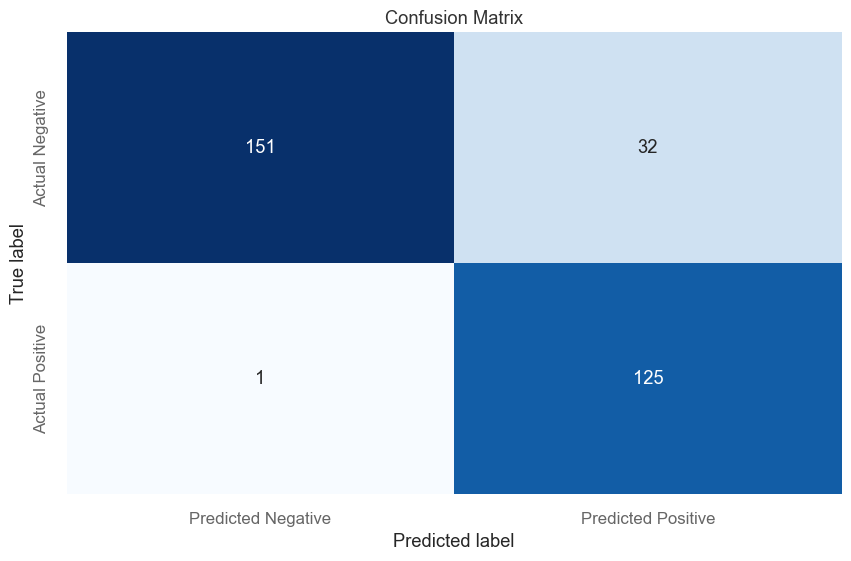

In [149]:
# Confusion Matrix
cm = confusion_matrix(y_test_trimmed, y_pred)
print("Confusion Matrix:")
print(cm)

# Display Confusion Matrix as a nicely formatted table
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

**Breakdown of the Confusion Matrix:**

  - **TN (151):**
    - This value represents the number of instances where the actual label was negative (i.e., the SPY ETF did not experience an uptrend), and the model correctly predicted it as negative. In this case, 151 out of all test  instances were correctly identified as negatives.
 - **FP (32):**
   - This value represents the number of instances where the actual label was negative, but the model incorrectly predicted it as positive. These are the false positives. In this case, the model incorrectly predicted an uptrend in 32 instances where there was none.
 - **FN (1):**
   - This value represents the number of instances where the actual label was positive (i.e., the SPY ETF experienced an uptrend), but the model incorrectly predicted it as negative. This is a false negative. Here, the model failed to identify 1 actual uptrend.
- **TP (125):**
  - This value represents the number of instances where the actual label was positive, and the model correctly predicted it as positive. The model correctly identified 125 uptrends.

**Interpretation of the Results:**

  - **High True Positives (TP = 125):**
    - The model is highly effective at identifying uptrends, correctly predicting 125 out of the 126 actual uptrends (TP + FN). This indicates that the model is very sensitive (high recall) and is adept at capturing most of the actual positive signals.
  - **Low False Negatives (FN = 1):**
    - The model has a very low number of false negatives, meaning it rarely misses an uptrend when one actually occurs. This low number is crucial for the trading strategy as it minimizes missed opportunities.
 - **Moderate False Positives (FP = 32):**
   - There is a moderate number of false positives, where the model incorrectly predicted an uptrend when there wasn't one. In the context of trading, this could lead to entering positions that may not be profitable, which could affect overall portfolio performance.
- **High True Negatives (TN = 151):**
  - The model also performs well in identifying periods where there is no uptrend, with 151 correct predictions out of 183 (TN + FP) actual negative instances. This helps avoid unnecessary trades, reducing the potential for losses from entering positions at the wrong time.


#### Classification Report of the Best Model (LSTM Single Layer)

In [150]:
# Classification Report
report = classification_report(y_test_trimmed, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90       183
         1.0       0.80      0.99      0.88       126

    accuracy                           0.89       309
   macro avg       0.89      0.91      0.89       309
weighted avg       0.91      0.89      0.89       309



**Interpretation:**

 - **Class  (No Uptrend):**
     - The model exhibits very high precision, indicating a strong ability to avoid false positives when predicting no uptrend. However, with a recall of 0.83, it may occasionally miss true "No Uptrend" signals.
 - **Class 1 (Uptrend):**
   - The model has a very high recall of 0.99, meaning it rarely misses an actual uptrend, which is essential for trading strategies that rely on capturing upward movements. The precision is lower at 0.80, suggesting that some predicted uptrends might be false alarms.
 - **Balanced Performance:**
   - The high recall for Class 1.0 (uptrend) ensures that the model captures almost all opportunities, which is critical in financial trading. The slightly lower precision indicates that some caution is needed, as not all predicted uptrends will materialize.

- Overall, this classification report highlights that the model is particularly effective at identifying true uptrends, with a very high recall rate, making it well-suited for trading strategies where capturing upward movements is more critical than avoiding false positives. The slight trade-off in precision for uptrends is balanced by the high recall, ensuring that most opportunities are not missed.

#### Balanced Accurcay of the Best Model (LSTM Single Layer)


**Balanced Accuracy** is a metric that provides a more nuanced view of a model's performance, especially when dealing with imbalanced datasets. It is the average of the true positive rate (TPR) and true negative rate (TNR), offering a balance between sensitivity and specificity.

**Formula:**

$$
\text{Balanced Accuracy} = \frac{\text{TPR} + \text{TNR}}{2}
$$

**Where:**

- **TPR (True Positive Rate)**: Also known as recall, it measures the proportion of actual positives that are correctly identified by the model.
- **TNR (True Negative Rate)**: It measures the proportion of actual negatives that are correctly identified by the model.


In [151]:
# Balanced Accuracy
balanced_acc = balanced_accuracy_score(y_test_trimmed, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

Balanced Accuracy: 0.9086


**Interpretation of Balanced Accuracy: 0.9086**

  - **Value Interpretation:**
    - A balanced accuracy of 0.9086 indicates that, on average, the model correctly identifies approximately 90.86% of both the positive and negative classes. 
    - This is a strong indicator of the model’s ability to handle both classes well, particularly in a situation where the dataset may be imbalanced.
    
    
- Overall, a balanced accuracy of 0.9086 suggests that the model performs very well across both positive and negative classes, making it reliable for use in the trading strategy where both capturing uptrends and avoiding false signals are critical.

#### ROC-AUC Analysis
  - The Receiver Operating Characteristic (ROC) curve is a graphical representation that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. 
  - The Area Under the ROC Curve (AUC) is a single scalar value that summarizes the performance of the classifier.

AUC: 0.9606


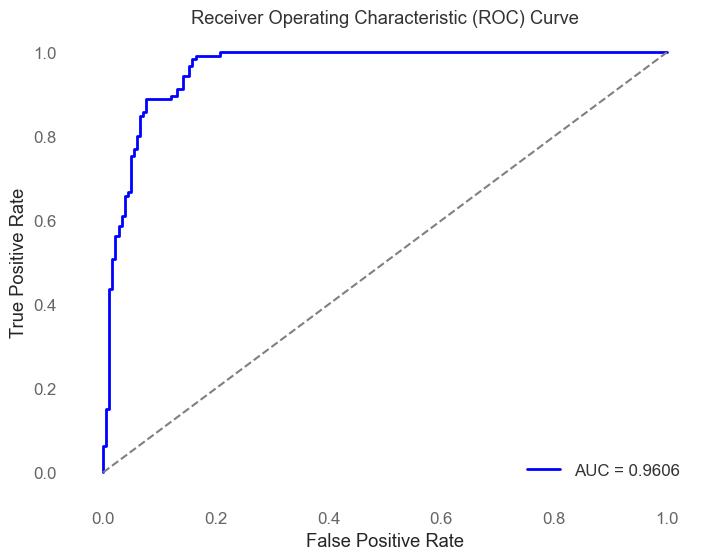

In [152]:
# Plot ROC Curve
from sklearn.metrics import roc_curve

# AUC
auc = roc_auc_score(y_test_trimmed, y_pred_prob)
print(f"AUC: {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test_trimmed, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

**Interpretation of the ROC-AUC in the Graph:**

  - **AUC = 0.9606:** This indicates that the model has a strong ability to distinguish between the positive and negative classes, with an AUC value close to 1. The model can correctly classify positive cases 96.06% of the time, which is a very good performance.
  - The ROC curve in the image shows that the model performs significantly better than random guessing (represented by the diagonal dashed line), as the curve is much closer to the top left corner, indicating high sensitivity and low FPR.

###  Saving y_pred (model's predictions) on the test data as Signal to use in Trading Strategy

In [140]:
#'df' is our original DataFrame containing all the data
# y_pred is our best model's predictions on the test data

# Ensure the length of y_pred matches the length of the test portion
# Create a DataFrame for the test data (last 309 rows)
df_test = df.iloc[-len(y_pred):].copy()

# Add the predictions as a new column
df_test['Signal'] = y_pred  # 1 for buy, 0 for sell

df_test.to_csv("LSTM_Model_Signal_Test_Data.csv", index = True )

df_test

,date,daily_return,yield_spread,VXX_daily_return,UUP_daily_return,volume_tech,ADOSC_3_10,ADX_14,OBV,AOBV_SR_2,...,PIVOTS_TRAD_D_P,PIVOTS_TRAD_D_R3,PSL_12,PVOL,PVT,SLOPE_1,SMCtp_14_50_20_5,STDEV_30,Target,Signal
1437,2023-04-05,-0.002618,-0.49,-0.009178,0.002894,65200243.0,9.755913e+07,13.795051,-1.829899e+07,0.0,...,409.276667,418.636667,66.666667,2.657562e+10,-1.296695e+10,-1.07,-1.112537,6.497442,0.0,0
1438,2023-04-06,0.003901,-0.52,-0.017623,0.000722,63743345.0,1.018255e+08,14.138402,4.544436e+07,0.0,...,407.393333,413.033333,66.666667,2.608314e+10,-1.294209e+10,1.59,-9.946714,6.806184,1.0,0
1439,2023-04-10,0.001026,-0.59,-0.009660,0.005768,63681042.0,1.137047e+08,14.491270,1.091254e+08,0.0,...,408.116000,415.720000,75.000000,2.608439e+10,-1.293555e+10,0.42,-16.918295,7.118465,0.0,0
1440,2023-04-11,0.000269,-0.60,-0.009754,-0.003584,59297945.0,1.027176e+08,15.066452,1.684233e+08,0.0,...,408.423333,415.863333,75.000000,2.429555e+10,-1.293396e+10,0.11,-24.431616,7.406816,0.0,0
1441,2023-04-12,-0.004076,-0.54,0.006098,-0.005396,86420379.0,6.847982e+07,15.217157,8.200296e+07,0.0,...,409.940000,414.460000,66.666667,3.526384e+10,-1.296918e+10,-1.67,-27.228810,7.578515,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,2024-06-24,-0.003251,-0.46,-0.007972,-0.003436,45528654.0,3.742017e+07,26.137312,1.641817e+09,1.0,...,544.393333,549.653333,58.333333,2.471022e+10,-1.149704e+10,-1.77,-7.034976,7.967939,0.0,0
1742,2024-06-25,0.003851,-0.42,-0.017857,0.001034,38273346.0,3.392215e+07,26.493766,1.680090e+09,1.0,...,544.103333,552.763333,66.666667,2.085247e+10,-1.148231e+10,2.09,-10.189487,7.897289,1.0,1
1743,2024-06-26,0.001248,-0.39,-0.010909,0.004823,38550637.0,3.609444e+07,27.023626,1.718641e+09,0.0,...,544.156667,549.676667,75.000000,2.102976e+10,-1.147750e+10,0.68,-20.033204,7.778476,0.0,1
1744,2024-06-27,0.001577,-0.41,-0.006434,-0.001371,35041480.0,3.925285e+07,27.653751,1.753682e+09,0.0,...,544.926667,551.346667,75.000000,1.914561e+10,-1.147197e+10,0.86,-25.013835,7.748247,0.0,0


- **Adding the Prediction as [Signals]:**
   -  New column, Signal, to df_test. This column contains the predictions (y_pred) from our best model. Each row in this column indicates the model's signal for that particular day:
      - 1: Buy Signal
      - 0: Sell Signal

  - Saving the DataFrame:
      - The df_test DataFrame, now including the model's signals, is saved to a CSV file named LSTM_Model_Signal_Test_Data.csv. 
      - This file can be used for further analysis, such as backtesting trading strategies based on the model's signals.

#### Please Note that Complete Trading Strategy Logic and Backtesting Part is in Notebook-3 (DL-NayanP-Notebook-3) ipynb

### References

#### CQF Program Materials

#### Kannan Singaravelu, CQF
- 1.JA24P1 Introduction to Financial Times Series. Certificate in Quantitative Finance (CQF) Program, 2024.
- 2.JA24P9 Introduction to Machine Learning using Scikit-learn. Certificate in Quantitative Finance (CQF) Program, 2024.
- 3.JA24P10 Trend Prediction using Logistic Regression. Certificate in Quantitative Finance (CQF) Program, 2024.
- 4.JA24P13 Application of Neural Networks using TensorFlow & Keras. Certificate in Quantitative Finance (CQF) Program, 2024. 
- 5.Advanced Machine Learning Workshop Notes and Python Files. Certificate in Quantitative Finance (CQF) Program**
- 6.CQF Final Project Tutorial III - Deep Learning & Machine Learning. Certificate in Quantitative Finance (CQF) Program, 2024


#### Python Libraries:
- 1.Pandas: Used for Data manipulation and analysis.
- 2.NumPy: Utilized for numerical operations.
- 3.Matplotlib & Seaborn: Used for data visualization.
- 4.Scikit-Learn: Used for various machine learning tasks.
- 5.TensorFlow & Keras: Core libraries for building, training, and optimizing the Long Short-Term Memory (LSTM) models.
- 6.Keras Tuner: Used for hyperparameter tuning.
- 7.SciPy: Utilized for advanced statistical functions and operations.



